# Working with time-series with two datasets: Chloropyll from Copernicus and Temperature from Kaggle
I made here some visulalisation and use different approaches like SARIMA or ML models to predict target
and SARIMA for make forecast

#### links to datasets

**Chlorophyll**

https://data.marine.copernicus.eu/product/OMI_HEALTH_CHL_ARCTIC_OCEANCOLOUR_area_averaged_mean/description

**Temperature**

https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCountry.csv

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns
import statsmodels.api as sm
import time

import xarray as xr
import os
import netCDF4

from datetime import datetime, timedelta
from itertools import product

from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit  
# from sklearn.model_selection import RandomizedSearchCV 

### metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

### models

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor      
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression  
from sklearn.neighbors import KNeighborsRegressor   
from lightgbm import LGBMRegressor             
from xgboost import XGBRegressor                   
from catboost import CatBoostRegressor           
from sklearn. linear_model import Ridge
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb        
import xgboost as xgb
#import tensorflow as tf

import warnings                                    
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format  
random_state=12345

# Chlorofill Time-Series from Copernicus

In [2]:
path_chl = 'C:/Users/v.kozlovskiy/Desktop/_Data_collection_external/DATA_OUTER-20231027T194031Z-001/DATA_OUTER/Copernicus_time_series_chla/OMI_HEALTH_CHL_ARCTIC_OCEANCOLOUR_area_averaged_mean_19970901_20211231_20220831.nc'

## Take data from ncdf

In [3]:
# i try but couldn`t use xarray here and take another way
#chl = xr.open_dataset(path_chl)

In [4]:
#chl

In [5]:
#chla = chl.to_dataframe()

In [6]:
f = netCDF4.Dataset(path_chl)
print(f) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Mean chlorophyll value for the Arctic Ocean over time
    area: ARC
    Conventions: CF-1.7
    references: http://marine.copernicus.eu/
    source: OCEANCOLOUR_ARC_BGC_L3_MY_009_123
    licence: http://marine.copernicus.eu/services-portfolio/service-commitments-and-license/
    institution: Plymouth Marine Laboratory
    credit: E.U. Copernicus Marine Service Information
    contact: https://marine.copernicus.eu/contact
    dimensions(sizes): 
    variables(dimensions): 
    groups: time_monthly, time_daily


In [7]:
f.groups

{'time_monthly': <class 'netCDF4._netCDF4.Group'>
 group /time_monthly:
     dimensions(sizes): time(291)
     variables(dimensions): int32 time(time), float32 chlor_deseasonalized(time)
     groups: ,
 'time_daily': <class 'netCDF4._netCDF4.Group'>
 group /time_daily:
     dimensions(sizes): time(5657)
     variables(dimensions): int32 time(time), float32 chlor_a(time)
     groups: }

In [8]:
f.groups['time_monthly'].variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: days since 1950-01-01 00:00:00
     standard_name: time
     calendar: gregorian
     axis: T
 path = /time_monthly
 unlimited dimensions: time
 current shape = (291,)
 filling on, default _FillValue of -2147483647 used,
 'chlor_deseasonalized': <class 'netCDF4._netCDF4.Variable'>
 float32 chlor_deseasonalized(time)
     units: mg m^-3
     long_name: Mean monthly concentration of deseasonalized chlorophyll over time
     standard_name: mass_concentration_of_chlorophyll_in_seawater
 path = /time_monthly
 unlimited dimensions: time
 current shape = (291,)
 filling on, default _FillValue of 9.969209968386869e+36 used}

In [9]:
#pd.to_datetime('1950-01-01').date() 

In [10]:
# function for conversion time (from 01.01.1950) 
def time_convertion(row):
    a = '1950-01-01'
    dt = datetime.strptime(a, '%Y-%m-%d')
    result = dt + timedelta(days=row)
    return result

,chlf,time
0,0.96,1997-09-09
1,2.33,1997-09-10
2,0.66,1997-09-15
3,0.78,1997-09-16
4,0.53,1997-09-18
...,...,...
5652,0.98,2021-10-15
5653,1.03,2021-10-16
5654,0.81,2021-10-17
5655,0.87,2021-10-18


<AxesSubplot:xlabel='time', ylabel='chlf'>

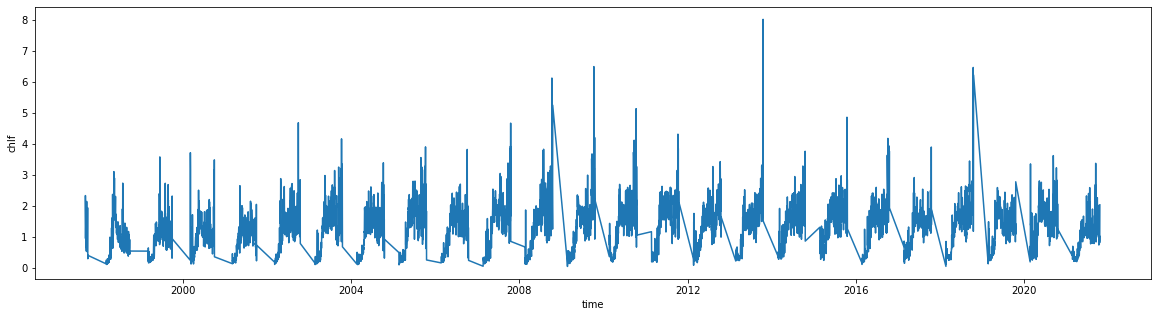

In [11]:
chlf_d = np.array(f.groups['time_daily']['chlor_a'][:])
time_d = np.array(f.groups['time_daily']['time'][:])
tab_d = pd.DataFrame({'chlf': chlf_d, 'time': time_d})
tab_d['time'] = tab_d['time'].apply(time_convertion)
display(tab_d)
plt.figure(figsize=(20, 5))
sns.lineplot(data = tab_d, x='time', y='chlf')

,chlf,time
0,1.06,1997-10-15
1,1.13,1997-11-15
2,1.12,1997-12-15
3,1.20,1998-01-15
4,1.20,1998-02-15
...,...,...
286,1.46,2021-08-15
287,1.14,2021-09-15
288,1.14,2021-10-15
289,1.18,2021-11-15


<AxesSubplot:xlabel='time', ylabel='chlf'>

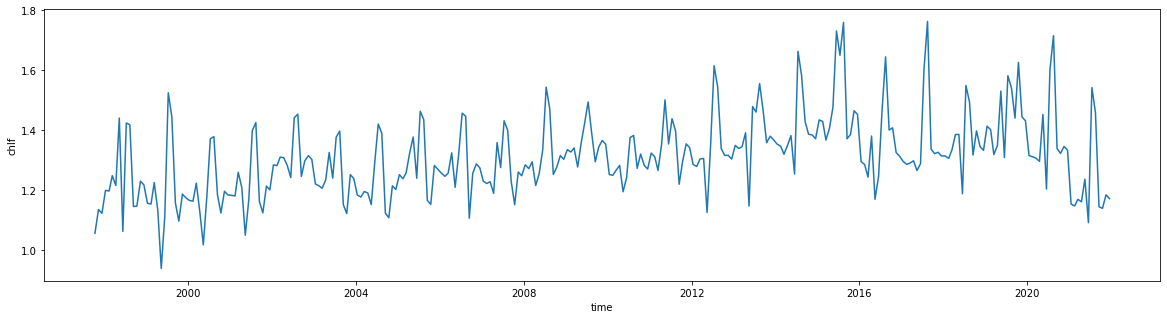

In [12]:
chlf_m = np.array(f.groups['time_monthly']['chlor_deseasonalized'][:])
time_m = np.array(f.groups['time_monthly']['time'][:])
tab_m = pd.DataFrame({'chlf': chlf_m, 'time': time_m})
tab_m['time'] = tab_m['time'].apply(time_convertion)
display(tab_m)
plt.figure(figsize=(20, 5))
sns.lineplot(data = tab_m, x='time', y='chlf')

In [13]:
tab_m = tab_m.set_index('time')

In [14]:
tab_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 291 entries, 1997-10-15 to 2021-12-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chlf    291 non-null    float32
dtypes: float32(1)
memory usage: 3.4 KB


In [15]:
tab_m

,chlf
time,
1997-10-15,1.06
1997-11-15,1.13
1997-12-15,1.12
1998-01-15,1.20
1998-02-15,1.20
...,...
2021-08-15,1.46
2021-09-15,1.14
2021-10-15,1.14


In [16]:
tab_d = tab_d.set_index('time')
tab_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5657 entries, 1997-09-09 to 2021-10-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chlf    5657 non-null   float32
dtypes: float32(1)
memory usage: 66.3 KB


In [17]:
tab_d

,chlf
time,
1997-09-09,0.96
1997-09-10,2.33
1997-09-15,0.66
1997-09-16,0.78
1997-09-18,0.53
...,...
2021-10-15,0.98
2021-10-16,1.03
2021-10-17,0.81


## Veiw to time-series

### basic visualisation and seasonal decompose

In [18]:
tab_m.index.is_monotonic

True

In [19]:
tab_d.index.is_monotonic

True

Text(0.5, 1.0, 'Chlorofill boxplot')

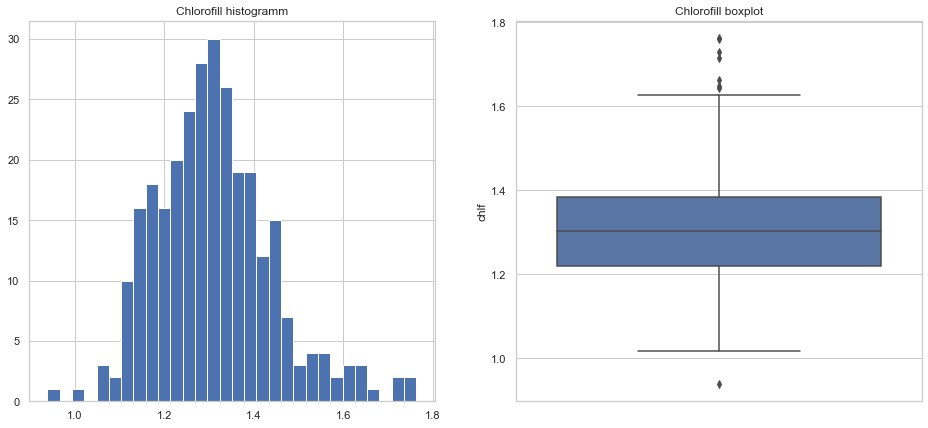

In [20]:
# basic graphs
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.subplot(1, 2, 1)
tab_m['chlf'].hist(bins=30)
plt.title('Chlorofill histogramm')

plt.subplot(1, 2, 2)
sns.boxplot(y=tab_m['chlf'])
plt.title('Chlorofill boxplot')

<AxesSubplot:xlabel='time', ylabel='chlf'>

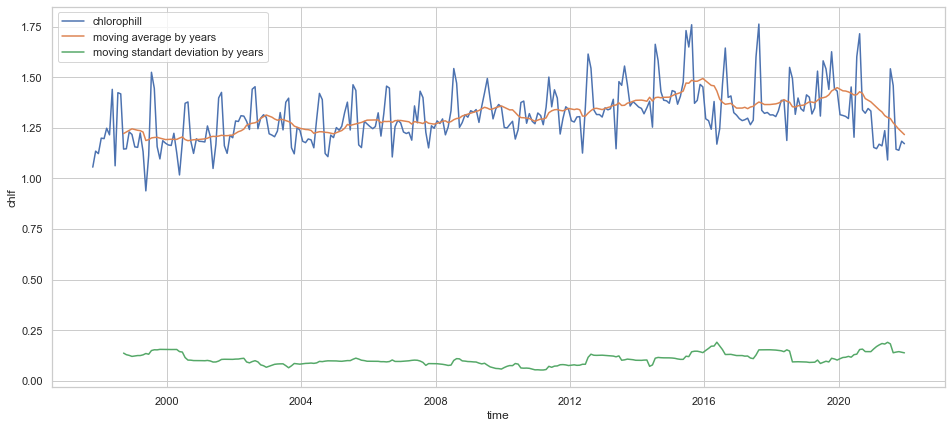

In [21]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(data=tab_m, x=tab_m.index, y=tab_m['chlf'], label='chlorophill')
sns.lineplot(data=tab_m, x=tab_m.index, y=tab_m['chlf'].rolling(12).mean(), label='moving average by years')
sns.lineplot(data=tab_m, x=tab_m.index, y=tab_m['chlf'].rolling(12).std(), label='moving standart deviation by years')

In [22]:
decomposed = seasonal_decompose(tab_m, model='additive', period=12)

<AxesSubplot:xlabel='time'>

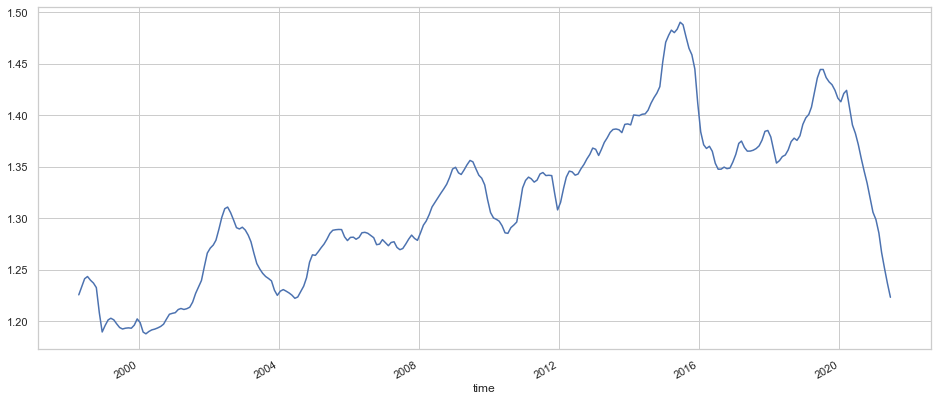

In [23]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
decomposed.trend.plot()

<AxesSubplot:xlabel='time'>

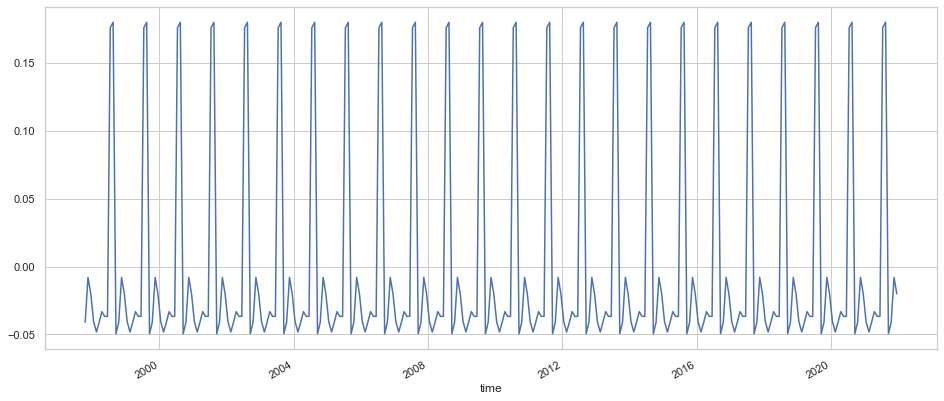

In [24]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
decomposed.seasonal.plot()

<AxesSubplot:xlabel='time'>

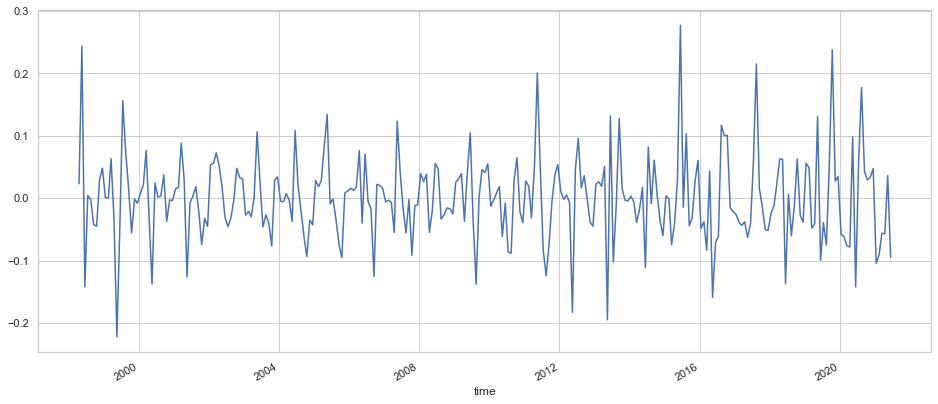

In [25]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
decomposed.resid.plot()

In [26]:
tab_m

,chlf
time,
1997-10-15,1.06
1997-11-15,1.13
1997-12-15,1.12
1998-01-15,1.20
1998-02-15,1.20
...,...
2021-08-15,1.46
2021-09-15,1.14
2021-10-15,1.14


In [27]:
tab_d

,chlf
time,
1997-09-09,0.96
1997-09-10,2.33
1997-09-15,0.66
1997-09-16,0.78
1997-09-18,0.53
...,...
2021-10-15,0.98
2021-10-16,1.03
2021-10-17,0.81


In [28]:
p = sm.tsa.stattools.adfuller(tab_m.chlf)[1]
print(f'Dickey–Fuller test: p-value={p}')

Dickey–Fuller test: p-value=0.3485990101875851


<AxesSubplot:xlabel='time', ylabel='chlf'>

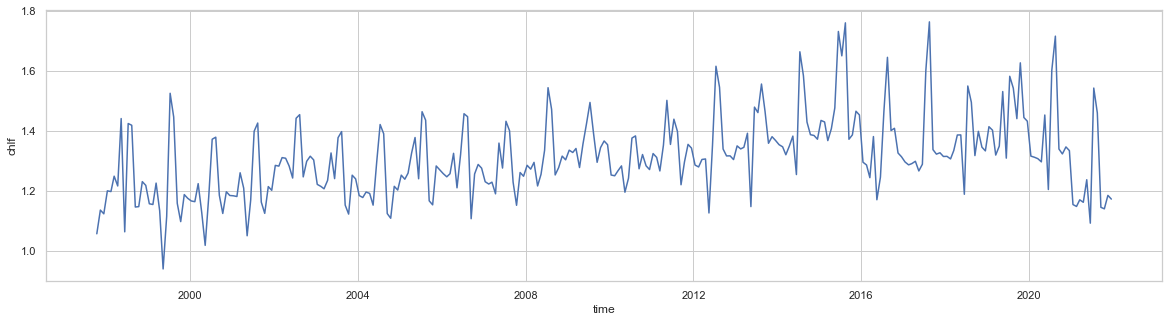

In [29]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = tab_m, x=tab_m.index, y='chlf')

# Non-ML approaches

## ARIMA

In [30]:
# data for ARIMA
train_size = int(tab_d.shape[0] * 0.9)
df_train = tab_d.iloc[:train_size]
df_test = tab_d.iloc[train_size:]

print(df_train.shape)
print(df_test.shape)

(5091, 1)
(566, 1)


In [31]:
# ARIMA fiting
model = ARIMA(df_train['chlf'], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   chlf   No. Observations:                 5091
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3421.169
Date:                Mon, 13 Nov 2023   AIC                           6848.339
Time:                        17:09:43   BIC                           6867.944
Sample:                             0   HQIC                          6855.204
                               - 5091                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1611      0.010     16.791      0.000       0.142       0.180
ma.L1         -0.7438      0.008    -88.217      0.000      -0.760      -0.727
sigma2         0.2245      0.002    142.240      0.0

In [32]:
# making forecast by fitied model
forecast = model_fit.forecast(steps=df_test.shape[0])
forecast[0:5]

5091   1.15
5092   1.21
5093   1.22
5094   1.23
5095   1.23
Name: predicted_mean, dtype: float64

In [33]:
compare = pd.Series(forecast)
compare.index = df_test['chlf'].index
compare.shape
compare[0:5]

time
2019-07-29   1.15
2019-07-30   1.21
2019-07-31   1.22
2019-08-01   1.23
2019-08-02   1.23
Name: predicted_mean, dtype: float64

In [34]:
# MSE and MAE
mse = mean_squared_error(df_test['chlf'], compare)**0.5
mae = mean_absolute_error(df_test['chlf'], compare)

print(f'RMSE: {mse}')
print(f'MAE: {mae}')

RMSE: 0.6348965655722608
MAE: 0.5017542265964909


<AxesSubplot:xlabel='time', ylabel='chlf'>

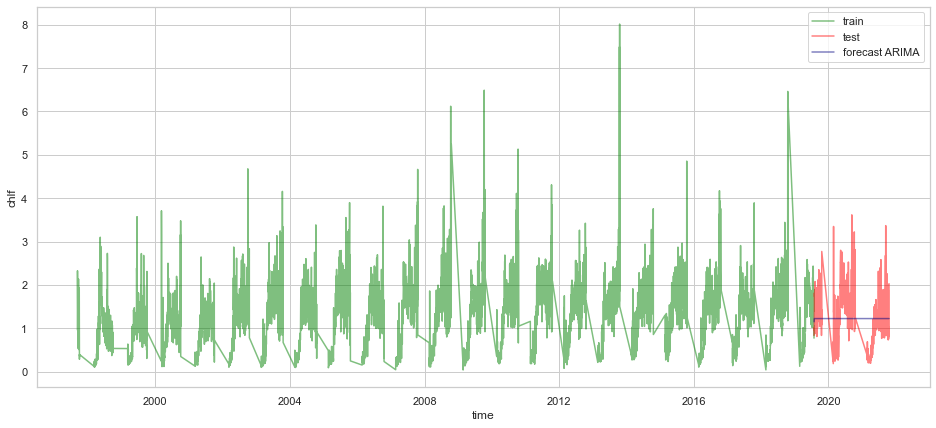

In [35]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_train['chlf'].index, y = df_train['chlf'], alpha=0.5, color='green', label='train')
sns.lineplot(x = df_test['chlf'].index, y = df_test['chlf'], alpha=0.5, color='red', label='test')
sns.lineplot(x = compare.index, y = compare, alpha=0.5, color ='navy', label='forecast ARIMA')

## SARIMA

In [36]:
model = SARIMAX(df_train['chlf'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              chlf   No. Observations:                 5091
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -3435.155
Date:                           Mon, 13 Nov 2023   AIC                           6880.309
Time:                                   17:09:51   BIC                           6912.978
Sample:                                        0   HQIC                          6891.750
                                          - 5091                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1688      0.010     17.268      0.000       0.150       0.188
ma.L1         -0.7478      0.008    -88.365

In [37]:
forecast = model_fit.forecast(steps=df_test.shape[0])
forecast[0:5]

5091   1.12
5092   1.20
5093   1.21
5094   1.21
5095   1.24
Name: predicted_mean, dtype: float64

In [38]:
compare = pd.Series(forecast)
compare.index = df_test['chlf'].index
compare.shape
compare[0:5]

time
2019-07-29   1.12
2019-07-30   1.20
2019-07-31   1.21
2019-08-01   1.21
2019-08-02   1.24
Name: predicted_mean, dtype: float64

In [39]:
mse = mean_squared_error(df_test['chlf'], compare)**0.5
mae = mean_absolute_error(df_test['chlf'], compare)

print(f'RMSE: {mse}')
print(f'MAE: {mae}')

RMSE: 0.6363903809898898
MAE: 0.5024813191710978


<AxesSubplot:xlabel='time', ylabel='chlf'>

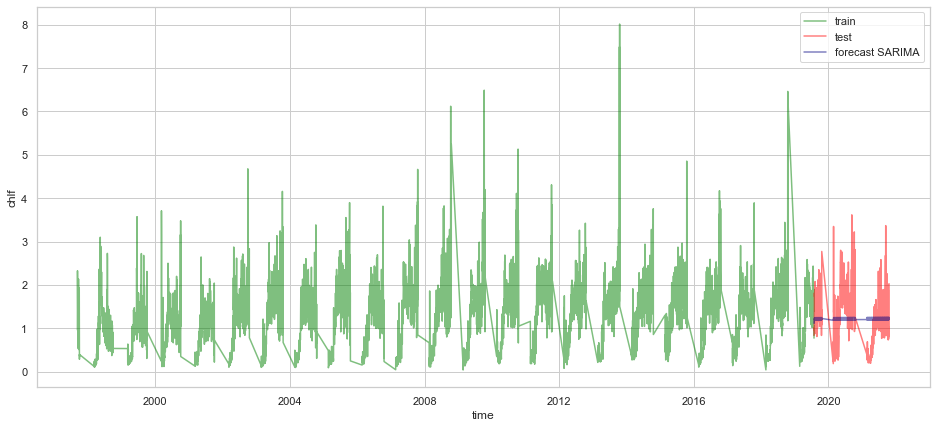

In [40]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_train['chlf'].index, y = df_train['chlf'], alpha=0.5, color='green', label='train')
sns.lineplot(x = df_test['chlf'].index, y = df_test['chlf'], alpha=0.5, color='red', label='test')
sns.lineplot(x = compare.index, y = compare, alpha=0.5, color ='navy', label='forecast SARIMA')

# making the time-series stacionary

## making the time-series stacionary before SARIMA

In [41]:
#data2 = tab_m.loc[data2['num_orders'] > 0]

data2 = tab_m
data2['boxcox'], lmbda = stats.boxcox(data2['chlf'])
data2['boxcox_shifted_S'] = data2.boxcox - data2.boxcox.shift(12)
data2['boxcox_shifted'] = data2.boxcox_shifted_S - data2.boxcox_shifted_S.shift(1)
data2 = data2[15:]

train_size = int(data2.shape[0] * 0.9)

#df_train = data2.iloc[:train_size]
#df_test = data2.iloc[train_size:]

train_size = -36
df_train = data2.iloc[:-36]
df_test = data2.iloc[-36:]


print(df_train.shape)
print(df_test.shape)

data2

(240, 4)
(36, 4)


,chlf,boxcox,boxcox_shifted_S,boxcox_shifted
time,,,,
1999-01-15,1.16,0.14,-0.03,-0.10
1999-02-15,1.15,0.13,-0.03,-0.00
1999-03-15,1.22,0.19,-0.02,0.02
1999-04-15,1.13,0.12,-0.06,-0.05
1999-05-15,0.94,-0.07,-0.38,-0.32
...,...,...,...,...
2021-08-15,1.46,0.33,-0.11,-0.09
2021-09-15,1.14,0.13,-0.13,-0.02
2021-10-15,1.14,0.12,-0.13,0.01


In [42]:
p = sm.tsa.stattools.adfuller(data2.boxcox_shifted)[1]
print(f'Dickey–Fuller test: p-value={p}')

Dickey–Fuller test: p-value=9.182216605784562e-08


In [43]:
def resore_prediction(y_pred):
    y_pred += data2.boxcox_shifted_S.shift(1)[-36:]
    y_pred += data2.boxcox.shift(12)[-36:]
    y_pred = inv_boxcox(y_pred, lmbda)
    return y_pred

In [44]:
# SARIMA fiting
model = SARIMAX(df_train['boxcox_shifted'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    boxcox_shifted   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 278.738
Date:                           Mon, 13 Nov 2023   AIC                           -547.477
Time:                                   17:09:52   BIC                           -530.243
Sample:                                        0   HQIC                          -540.527
                                           - 240                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4476      0.048     -9.397      0.000      -0.541      -0.354
ma.L1         -0.9972      0.215     -4.645

In [45]:
df_test.shape[0]

36

In [46]:
forecast = model_fit.forecast(steps=df_test.shape[0])
forecast[0:5]

240   -0.02
241    0.02
242   -0.02
243   -0.00
244    0.01
Name: predicted_mean, dtype: float64

In [47]:
compare = pd.Series(forecast)
compare.index = df_test['boxcox_shifted'].index
print(compare.shape)
compare[0:5]

(36,)


time
2019-01-15   -0.02
2019-02-15    0.02
2019-03-15   -0.02
2019-04-15   -0.00
2019-05-15    0.01
Name: predicted_mean, dtype: float64

In [48]:
y_pred = resore_prediction(compare)

In [49]:
y_pred[0:5]

time
2019-01-15   1.31
2019-02-15   1.44
2019-03-15   1.40
2019-04-15   1.37
2019-05-15   1.37
Name: predicted_mean, dtype: float64

In [50]:
mse = mean_squared_error(df_test['chlf'], y_pred)**0.5
mae = mean_absolute_error(df_test['chlf'], y_pred)

print(f'RMSE: {mse}')
print(f'MAE: {mae}')

RMSE: 0.11391718038705907
MAE: 0.0880916975690893


<AxesSubplot:xlabel='time', ylabel='chlf'>

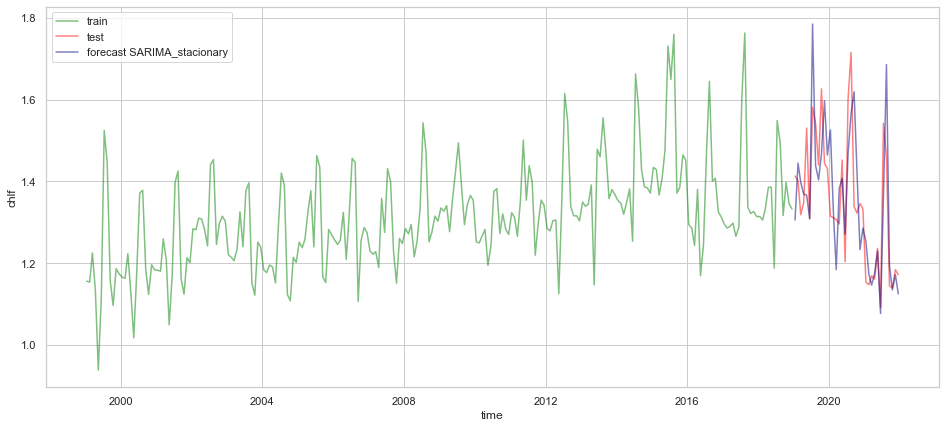

In [51]:
# visualisation
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_train['chlf'].index, y = df_train['chlf'], alpha=0.5, color='green', label='train')
sns.lineplot(x = df_test['chlf'].index, y = df_test['chlf'], alpha=0.5, color='red', label='test')
sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color ='navy', label='forecast SARIMA_stacionary')

### Attempt to forecast in future

In [52]:
data2.index.max()

Timestamp('2021-12-15 00:00:00')

In [53]:
model = SARIMAX(df_train['boxcox_shifted'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    boxcox_shifted   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                 278.738
Date:                           Mon, 13 Nov 2023   AIC                           -547.477
Time:                                   17:09:53   BIC                           -530.243
Sample:                                        0   HQIC                          -540.527
                                           - 240                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4476      0.048     -9.397      0.000      -0.541      -0.354
ma.L1         -0.9972      0.215     -4.645

In [54]:
forecast_future = model_fit.forecast(steps=df_test.shape[0])

# new dates
future_dates = pd.date_range(start='2022-01-15 00:00:00', periods=df_test.shape[0], freq='M')
#forecast_df = pd.DataFrame({'date': future_dates, 'boxcox_shifted': forecast_future})
#forecast_df = forecast_df.set_index('date')

def resore_prediction(y_pred):
    y_pred += data2.boxcox_shifted_S.shift(1)[train_size:]
    y_pred += data2.boxcox.shift(12)[train_size:]
    y_pred = inv_boxcox(y_pred, lmbda)
    return y_pred

In [55]:
compare = pd.Series(forecast_future)
compare.index = df_test['boxcox_shifted'].index
print(compare.shape)
compare[0:5]

(36,)


time
2019-01-15   -0.02
2019-02-15    0.02
2019-03-15   -0.02
2019-04-15   -0.00
2019-05-15    0.01
Name: predicted_mean, dtype: float64

In [56]:
y_pred = resore_prediction(compare)
y_pred[0:5]

time
2019-01-15   1.31
2019-02-15   1.44
2019-03-15   1.40
2019-04-15   1.37
2019-05-15   1.37
Name: predicted_mean, dtype: float64

In [57]:
y_pred.index = future_dates
y_pred[0:5]

2022-01-31   1.31
2022-02-28   1.44
2022-03-31   1.40
2022-04-30   1.37
2022-05-31   1.37
Freq: M, Name: predicted_mean, dtype: float64

<AxesSubplot:xlabel='time', ylabel='chlf'>

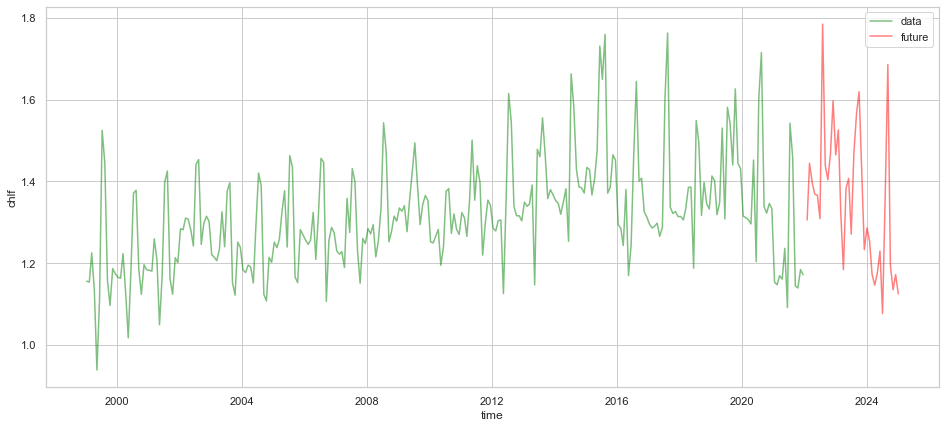

In [58]:
# forecast with real data
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = data2['chlf'].index, y = data2['chlf'], alpha=0.5, color='green', label='data')
sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color='red', label='future')
#sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color ='navy', label='forecast SARIMA_stacionary')

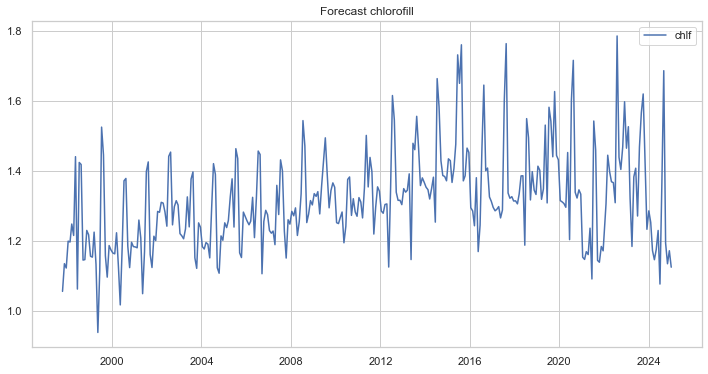

In [59]:
# forecast with real data in one graph
tab_exp = pd.concat([pd.DataFrame({'chlf': tab_m['chlf']}), pd.DataFrame({'chlf':y_pred})], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(tab_exp.index, tab_exp['chlf'], label='chlf')

plt.title('Forecast chlorofill')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Forecast chlorofill')

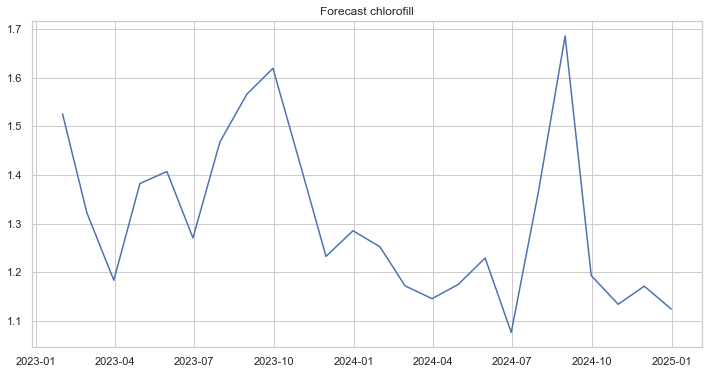

In [60]:
# check conection between real and forecast
tab_exp2 = tab_exp.loc[(tab_exp.index.year >= 2023) & (tab_exp.index.year <= 2024)]
plt.figure(figsize=(12, 6))
plt.plot(tab_exp2.index, tab_exp2['chlf'], label='chlorofill')
plt.title('Forecast chlorofill')

# ML approaches

In [61]:
# function for make features
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['year'] = data.index.year    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['chlf'].shift(lag)
    data['rolling_mean_year'] = data['chlf'].shift().rolling(12).mean()
    return data

In [62]:
data2 = tab_d
data2['boxcox'], lmbda = stats.boxcox(data2['chlf'])
data2['boxcox_shifted_S'] = data2.boxcox - data2.boxcox.shift(12)
data2['boxcox_shifted'] = data2.boxcox_shifted_S - data2.boxcox_shifted_S.shift(1)
#data2 = data2[15:]

In [63]:
data2 = make_features(data2, 1)
#data2 = data2[12:]
data2 = data2[15:] # tab_d !
data2

,chlf,boxcox,boxcox_shifted_S,boxcox_shifted,month,year,lag_1,rolling_mean_year
time,,,,,,,,
1997-09-29,1.94,0.81,1.04,0.13,9,1997,1.59,1.01
1997-09-30,0.97,-0.03,0.49,-0.55,9,1997,1.94,1.11
1997-10-01,0.29,-0.87,-0.71,-1.21,10,1997,0.97,1.15
1997-10-02,0.40,-0.70,-1.04,-0.33,10,1997,0.29,1.10
1997-10-03,0.36,-0.76,-1.73,-0.69,10,1997,0.40,1.02
...,...,...,...,...,...,...,...,...
2021-10-15,0.98,-0.02,-0.08,0.51,10,2021,0.75,1.29
2021-10-16,1.03,0.03,-0.46,-0.39,10,2021,0.98,1.28
2021-10-17,0.81,-0.20,-0.65,-0.18,10,2021,1.03,1.24


In [64]:
# taking feature and target
features = data2.drop(['chlf'], axis=1)
target = data2['chlf']

In [65]:
features

,boxcox,boxcox_shifted_S,boxcox_shifted,month,year,lag_1,rolling_mean_year
time,,,,,,,
1997-09-29,0.81,1.04,0.13,9,1997,1.59,1.01
1997-09-30,-0.03,0.49,-0.55,9,1997,1.94,1.11
1997-10-01,-0.87,-0.71,-1.21,10,1997,0.97,1.15
1997-10-02,-0.70,-1.04,-0.33,10,1997,0.29,1.10
1997-10-03,-0.76,-1.73,-0.69,10,1997,0.40,1.02
...,...,...,...,...,...,...,...
2021-10-15,-0.02,-0.08,0.51,10,2021,0.75,1.29
2021-10-16,0.03,-0.46,-0.39,10,2021,0.98,1.28
2021-10-17,-0.20,-0.65,-0.18,10,2021,1.03,1.24


In [66]:
# use one hot encoder for months (for linear models)

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(np.array(features['month']).reshape(-1,1)).toarray())
encoder_df.index = features.index

#merge one-hot encoded columns back with original DataFrame
features_ohe = features.join(encoder_df)
features_ohe = features_ohe.drop('month', axis= 1)

display(features_ohe)

,boxcox,boxcox_shifted_S,boxcox_shifted,year,lag_1,rolling_mean_year,0,1,2,3,4,5,6,7,8
time,,,,,,,,,,,,,,,
1997-09-29,0.81,1.04,0.13,1997,1.59,1.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1997-09-30,-0.03,0.49,-0.55,1997,1.94,1.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1997-10-01,-0.87,-0.71,-1.21,1997,0.97,1.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1997-10-02,-0.70,-1.04,-0.33,1997,0.29,1.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1997-10-03,-0.76,-1.73,-0.69,1997,0.40,1.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-15,-0.02,-0.08,0.51,2021,0.75,1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2021-10-16,0.03,-0.46,-0.39,2021,0.98,1.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2021-10-17,-0.20,-0.65,-0.18,2021,1.03,1.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [67]:
# data split
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)
X_train_ohe, X_test_ohe = train_test_split(features_ohe, shuffle=False, test_size=0.1)

print(X_train.shape)
print(X_test.shape)
print(X_train_ohe.shape)
print(X_test_ohe.shape)
print(y_train.shape)
print(y_test.shape)

(5077, 7)
(565, 7)
(5077, 15)
(565, 15)
(5077,)
(565,)


In [68]:
# scaling

scaler = StandardScaler()

scaler.fit(X_train)           
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(X_train_ohe)           
X_train_ohe = scaler.transform(X_train_ohe)
X_test_ohe = scaler.transform(X_test_ohe)
print(X_train.shape)
print(X_test.shape)
print()
print(X_train_ohe.shape)
print(X_test_ohe.shape)

(5077, 7)
(565, 7)

(5077, 15)
(565, 15)


In [69]:
# function for cross-validation on consecutive segments divided with TimeSeriesSplit

def cross_val_TS(features, target, n_splits, model):
    tscv = TimeSeriesSplit(n_splits = n_splits)
    rmse_list = []
    features = pd.DataFrame(features)
    target = pd.Series(target)
    
    for train_index, test_index in tscv.split(features):
        cv_train, cv_test = features.iloc[train_index], features.iloc[test_index]
        cv_target_train, cv_target_test = target.iloc[train_index], target.iloc[test_index]
        model = model
        model.fit(cv_train, cv_target_train)
        predictions = model.predict(cv_test)
        rmse_score = mean_squared_error(cv_target_test, predictions)**0.5
        rmse_list.append(rmse_score)
    return np.mean(rmse_list)

## Validation

#### Linear

In [70]:
%%time
clf = LinearRegression()
cross_val_TS(X_train_ohe, y_train, 8, clf)

CPU times: total: 188 ms
Wall time: 30.8 ms


0.10396058327793221

#### Ridge

In [71]:
parametrs = {'alpha': np.arange(0, 5, 0.5),
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
solver_list = []
score_list = []
alpha_list = []
models_list = []

In [72]:
%%time
for a in parametrs['alpha']:
    for i in parametrs['solver']:
        alpha_list.append(a)
        solver_list.append(i)
        score_list.append(cross_val_TS(X_train_ohe, y_train, 8, clf))
        clf = Ridge(random_state=12345, solver=i, alpha=a)
        models_list.append(clf)
analysis = pd.DataFrame({'solver': solver_list,'alpha': alpha_list, 'score': score_list, 'model': models_list})
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_ridge_score = analysis['score'][0]
best_ridge_model = analysis['model'][0]
      
print(best_ridge_score)        
print(best_ridge_model) 

,index,solver,alpha,score,model
0,5,sag,0.00,0.10,"Ridge(alpha=0.0, random_state=12345, solver='s..."
1,12,sag,0.50,0.10,"Ridge(alpha=0.5, random_state=12345, solver='s..."
2,19,sag,1.00,0.10,"Ridge(random_state=12345, solver='sag')"
3,26,sag,1.50,0.10,"Ridge(alpha=1.5, random_state=12345, solver='s..."
4,33,sag,2.00,0.10,"Ridge(alpha=2.0, random_state=12345, solver='s..."
...,...,...,...,...,...
65,66,lsqr,4.50,0.10,"Ridge(alpha=4.5, random_state=12345, solver='l..."
66,65,cholesky,4.50,0.10,"Ridge(alpha=4.5, random_state=12345, solver='c..."
67,2,cholesky,0.00,"18,823,314,699.60","Ridge(alpha=0.0, random_state=12345, solver='c..."
68,1,svd,0.00,"18,823,314,699.60","Ridge(alpha=0.0, random_state=12345, solver='s..."


0.103301327300344
Ridge(alpha=0.0, random_state=12345, solver='sag')
CPU times: total: 15 s
Wall time: 3.12 s


#### Lasso

In [73]:
parametrs = {'alpha': np.arange(0, 5, 0.5),
            'selection': ['cyclic', 'random']}
selection = []
score_list = []
alpha_list = []
models_list = []

In [74]:
%%time
for a in parametrs['alpha']:
    for i in parametrs['selection']:
        alpha_list.append(a)
        selection.append(i)
        score_list.append(cross_val_TS(X_train_ohe, y_train, 8, clf))
        clf = linear_model.Lasso(random_state=12345, selection=i, alpha=a)
        models_list.append(clf)
analysis = pd.DataFrame({'selection': selection,'alpha': alpha_list, 'score': score_list, 'model': models_list})
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_lasso_score = analysis['score'][0]
best_lasso_model = analysis['model'][0]

        
print(best_lasso_score)        
print(best_lasso_model)

,index,selection,alpha,score,model
0,1,random,0.00,0.10,"Lasso(alpha=0.0, random_state=12345, selection..."
1,0,cyclic,0.00,0.10,"Lasso(alpha=0.0, random_state=12345)"
2,2,cyclic,0.50,0.11,"Lasso(alpha=0.5, random_state=12345)"
3,3,random,0.50,0.60,"Lasso(alpha=0.5, random_state=12345, selection..."
4,4,cyclic,1.00,0.60,Lasso(random_state=12345)
5,17,random,4.00,0.75,"Lasso(alpha=4.0, random_state=12345, selection..."
6,16,cyclic,4.00,0.75,"Lasso(alpha=4.0, random_state=12345)"
7,15,random,3.50,0.75,"Lasso(alpha=3.5, random_state=12345, selection..."
8,14,cyclic,3.50,0.75,"Lasso(alpha=3.5, random_state=12345)"
9,13,random,3.00,0.75,"Lasso(alpha=3.0, random_state=12345, selection..."


0.10418494758942658
Lasso(alpha=0.0, random_state=12345, selection='random')
CPU times: total: 5.97 s
Wall time: 1.05 s


#### KNN

In [75]:
parametrs = {'n_neighbors' : [2, 3, 5, 10],
             'leaf_size' : [10, 30, 50, 100, 200, 400],
             'algorithm' : ["auto",  "ball_tree", "kd_tree", "brute"]}

n_neighbors_list = []
alg_list = []
leaf_list = []
models_list = []
score_list = []

In [76]:
%%time
for l in parametrs['n_neighbors']:
    for a in parametrs['leaf_size']:
        for i in parametrs['algorithm']:
            n_neighbors_list.append(l)
            leaf_list.append(a)
            alg_list.append(i)
            clf = clf = KNeighborsRegressor(n_neighbors=l, leaf_size=a, algorithm=i)
            score_list.append(cross_val_TS(X_train, y_train, 8, clf))
            models_list.append(clf)

analysis = pd.DataFrame({'n_neighbors': n_neighbors_list,'leaf_size': leaf_list,
                             'algorithm': alg_list, 'model': models_list, 'score':score_list})
            
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_knn_score = analysis['score'][0]
best_knn_model = analysis['model'][0]

print(best_knn_score)        
print(best_knn_model)

,index,n_neighbors,leaf_size,algorithm,model,score
0,49,5,10,ball_tree,"KNeighborsRegressor(algorithm='ball_tree', lea...",0.18
1,50,5,10,kd_tree,"KNeighborsRegressor(algorithm='kd_tree', leaf_...",0.18
2,51,5,10,brute,"KNeighborsRegressor(algorithm='brute', leaf_si...",0.18
3,52,5,30,auto,KNeighborsRegressor(),0.18
4,53,5,30,ball_tree,KNeighborsRegressor(algorithm='ball_tree'),0.18
...,...,...,...,...,...,...
91,74,10,10,kd_tree,"KNeighborsRegressor(algorithm='kd_tree', leaf_...",0.19
92,73,10,10,ball_tree,"KNeighborsRegressor(algorithm='ball_tree', lea...",0.19
93,94,10,400,kd_tree,"KNeighborsRegressor(algorithm='kd_tree', leaf_...",0.19
94,82,10,50,kd_tree,"KNeighborsRegressor(algorithm='kd_tree', leaf_...",0.19


0.17671616353405145
KNeighborsRegressor(algorithm='ball_tree', leaf_size=10)
CPU times: total: 22.8 s
Wall time: 13.9 s


#### Decision tree

In [77]:
parametrs = {'max_depth': range (1, 50, 2)}

depth_list = []
models_list = []
score_list = []

In [78]:
%%time
for l in parametrs['max_depth']:
    depth_list.append(l)
    clf = DecisionTreeRegressor(random_state=12345, max_depth=l)
    score_list.append(cross_val_TS(X_train, y_train, 8, clf))
    models_list.append(clf)
analysis = pd.DataFrame({'max_depth': depth_list, 'score': score_list, 'model': models_list})
            
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_tree_score = analysis['score'][0]
best_tree_model = analysis['model'][0]

best_params_forest = {}

for col in analysis:
    if col is not 'score':
        best_params_forest.update({col : analysis[col][0]})
        
print(best_tree_score)        
print(best_tree_model)

,index,max_depth,score,model
0,4,9,0.05,"DecisionTreeRegressor(max_depth=9, random_stat..."
1,5,11,0.05,"DecisionTreeRegressor(max_depth=11, random_sta..."
2,12,25,0.05,"DecisionTreeRegressor(max_depth=25, random_sta..."
3,22,45,0.05,"DecisionTreeRegressor(max_depth=45, random_sta..."
4,21,43,0.05,"DecisionTreeRegressor(max_depth=43, random_sta..."
5,20,41,0.05,"DecisionTreeRegressor(max_depth=41, random_sta..."
6,19,39,0.05,"DecisionTreeRegressor(max_depth=39, random_sta..."
7,18,37,0.05,"DecisionTreeRegressor(max_depth=37, random_sta..."
8,17,35,0.05,"DecisionTreeRegressor(max_depth=35, random_sta..."
9,16,33,0.05,"DecisionTreeRegressor(max_depth=33, random_sta..."


0.04803937633453538
DecisionTreeRegressor(max_depth=9, random_state=12345)
CPU times: total: 2.5 s
Wall time: 2.5 s


#### Random Forest

In [79]:
parametrs = { 'max_depth': range (1, 50, 5),
            'n_estimators': range (1, 50, 5)}

score_list = []
model_list = []

In [80]:
%%time
for l in parametrs['max_depth']:
    for a in parametrs['n_estimators']:
        clf = RandomForestRegressor(random_state=12345, max_depth=l, n_estimators=a)
        score_list.append(cross_val_TS(X_train, y_train, 8, clf))
        model_list.append(clf)
        
analysis = pd.DataFrame({'model': model_list, 'score': score_list})
            
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_forest_score = analysis['score'][0]
best_forest_model = analysis['model'][0]

       
print(best_forest_score)        
print(best_forest_model)

,index,model,score
0,24,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.05
1,25,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.05
2,26,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.05
3,29,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.05
4,27,"(DecisionTreeRegressor(max_depth=11, max_featu...",0.05
...,...,...,...
95,9,"(DecisionTreeRegressor(max_depth=1, max_featur...",0.46
96,8,"(DecisionTreeRegressor(max_depth=1, max_featur...",0.46
97,7,"(DecisionTreeRegressor(max_depth=1, max_featur...",0.46
98,1,"(DecisionTreeRegressor(max_depth=1, max_featur...",0.46


0.04659324736704354
RandomForestRegressor(max_depth=11, n_estimators=21, random_state=12345)
CPU times: total: 2min 15s
Wall time: 2min 16s


#### CatBoost

In [81]:
# parameters
iterations = [2, 4, 6, 8, 10]
depth = [4, 6, 10] #, 20, 50, 100, 1000]
learning_rate = [0.001, 0.001, 0.03, 0.1, 1]

hyperparameter_grid = {'iterations': iterations,
    'depth': depth,
    'learning_rate': learning_rate}

models_list = []
score_list = []

In [82]:
%%time
counter=0
for l in hyperparameter_grid['learning_rate']:
    for a in hyperparameter_grid['depth']:
        for i in hyperparameter_grid['iterations']:
            clf = CatBoostRegressor(learning_rate=l, depth=a, iterations=i)
            score_list.append(cross_val_TS(X_train, y_train, 8, clf))
            models_list.append(clf)
analysis = pd.DataFrame({'model': models_list, 'score': score_list})
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_cb_score = analysis['score'][0]
best_cb_model = analysis['model'][0]
       
print(best_cb_score)        
print(best_cb_model)

0:	learn: 0.5776903	total: 141ms	remaining: 141ms
1:	learn: 0.5772133	total: 142ms	remaining: 0us
0:	learn: 0.6015008	total: 1.11ms	remaining: 1.11ms
1:	learn: 0.6009931	total: 1.93ms	remaining: 0us
0:	learn: 0.6475807	total: 17ms	remaining: 17ms
1:	learn: 0.6470167	total: 18.5ms	remaining: 0us
0:	learn: 0.6746269	total: 1.3ms	remaining: 1.3ms
1:	learn: 0.6740395	total: 2.56ms	remaining: 0us
0:	learn: 0.7266932	total: 33.8ms	remaining: 33.8ms
1:	learn: 0.7260645	total: 35.4ms	remaining: 0us
0:	learn: 0.7336654	total: 1.76ms	remaining: 1.76ms
1:	learn: 0.7330332	total: 3.56ms	remaining: 0us
0:	learn: 0.7386916	total: 1.17ms	remaining: 1.17ms
1:	learn: 0.7380655	total: 2.58ms	remaining: 0us
0:	learn: 0.7369548	total: 1.59ms	remaining: 1.59ms
1:	learn: 0.7363294	total: 3.06ms	remaining: 0us
0:	learn: 0.5776903	total: 657us	remaining: 1.97ms
1:	learn: 0.5772133	total: 1.41ms	remaining: 1.41ms
2:	learn: 0.5768182	total: 2.12ms	remaining: 705us
3:	learn: 0.5764586	total: 2.86ms	remaining: 0u

4:	learn: 0.5996225	total: 4.44ms	remaining: 4.44ms
5:	learn: 0.5991127	total: 5.68ms	remaining: 3.79ms
6:	learn: 0.5986520	total: 6.55ms	remaining: 2.81ms
7:	learn: 0.5981751	total: 7.32ms	remaining: 1.83ms
8:	learn: 0.5977147	total: 8.12ms	remaining: 902us
9:	learn: 0.5972000	total: 8.99ms	remaining: 0us
0:	learn: 0.6475807	total: 1.19ms	remaining: 10.7ms
1:	learn: 0.6470167	total: 2.24ms	remaining: 8.98ms
2:	learn: 0.6465270	total: 3.01ms	remaining: 7.02ms
3:	learn: 0.6459996	total: 3.87ms	remaining: 5.81ms
4:	learn: 0.6454596	total: 4.69ms	remaining: 4.69ms
5:	learn: 0.6448938	total: 5.49ms	remaining: 3.66ms
6:	learn: 0.6443551	total: 6.26ms	remaining: 2.68ms
7:	learn: 0.6438251	total: 7.27ms	remaining: 1.82ms
8:	learn: 0.6432814	total: 8.12ms	remaining: 901us
9:	learn: 0.6427121	total: 8.94ms	remaining: 0us
0:	learn: 0.6746269	total: 974us	remaining: 8.77ms
1:	learn: 0.6740395	total: 1.95ms	remaining: 7.81ms
2:	learn: 0.6735159	total: 15.5ms	remaining: 36.2ms
3:	learn: 0.6729509	t

1:	learn: 0.5772183	total: 3.19ms	remaining: 9.56ms
2:	learn: 0.5767393	total: 4.7ms	remaining: 7.83ms
3:	learn: 0.5763111	total: 6.07ms	remaining: 6.07ms
4:	learn: 0.5758944	total: 7.37ms	remaining: 4.42ms
5:	learn: 0.5754391	total: 9ms	remaining: 3ms
6:	learn: 0.5749973	total: 10.3ms	remaining: 1.47ms
7:	learn: 0.5745486	total: 11.6ms	remaining: 0us
0:	learn: 0.6014945	total: 1.63ms	remaining: 11.4ms
1:	learn: 0.6010243	total: 3.15ms	remaining: 9.45ms
2:	learn: 0.6004988	total: 4.5ms	remaining: 7.49ms
3:	learn: 0.5999921	total: 5.88ms	remaining: 5.88ms
4:	learn: 0.5994944	total: 7.22ms	remaining: 4.33ms
5:	learn: 0.5990101	total: 8.54ms	remaining: 2.85ms
6:	learn: 0.5985220	total: 9.84ms	remaining: 1.41ms
7:	learn: 0.5980116	total: 11.2ms	remaining: 0us
0:	learn: 0.6475690	total: 1.66ms	remaining: 11.6ms
1:	learn: 0.6470211	total: 3.22ms	remaining: 9.67ms
2:	learn: 0.6464344	total: 4.79ms	remaining: 7.99ms
3:	learn: 0.6458947	total: 6.2ms	remaining: 6.2ms
4:	learn: 0.6453581	total: 7

0:	learn: 0.6015355	total: 22.5ms	remaining: 67.6ms
1:	learn: 0.6010373	total: 43.3ms	remaining: 43.3ms
2:	learn: 0.6005344	total: 62.6ms	remaining: 20.9ms
3:	learn: 0.6000488	total: 81.5ms	remaining: 0us
0:	learn: 0.6476084	total: 19.7ms	remaining: 59ms
1:	learn: 0.6470571	total: 38.4ms	remaining: 38.4ms
2:	learn: 0.6464855	total: 57.2ms	remaining: 19.1ms
3:	learn: 0.6459430	total: 75.6ms	remaining: 0us
0:	learn: 0.6746412	total: 18.4ms	remaining: 55.1ms
1:	learn: 0.6740590	total: 37.5ms	remaining: 37.5ms
2:	learn: 0.6734476	total: 55.3ms	remaining: 18.4ms
3:	learn: 0.6728692	total: 73.8ms	remaining: 0us
0:	learn: 0.7266775	total: 5.13ms	remaining: 15.4ms
1:	learn: 0.7260547	total: 16.5ms	remaining: 16.5ms
2:	learn: 0.7254167	total: 34.5ms	remaining: 11.5ms
3:	learn: 0.7248053	total: 54ms	remaining: 0us
0:	learn: 0.7336598	total: 18.5ms	remaining: 55.4ms
1:	learn: 0.7330144	total: 36.9ms	remaining: 36.9ms
2:	learn: 0.7323576	total: 55.9ms	remaining: 18.6ms
3:	learn: 0.7317149	total: 7

1:	learn: 0.6470571	total: 45.3ms	remaining: 181ms
2:	learn: 0.6464855	total: 69.2ms	remaining: 161ms
3:	learn: 0.6459430	total: 91.8ms	remaining: 138ms
4:	learn: 0.6454056	total: 114ms	remaining: 114ms
5:	learn: 0.6448741	total: 137ms	remaining: 91.3ms
6:	learn: 0.6443507	total: 158ms	remaining: 67.8ms
7:	learn: 0.6437865	total: 177ms	remaining: 44.2ms
8:	learn: 0.6432506	total: 195ms	remaining: 21.6ms
9:	learn: 0.6427458	total: 212ms	remaining: 0us
0:	learn: 0.6746412	total: 18.7ms	remaining: 168ms
1:	learn: 0.6740590	total: 37.1ms	remaining: 148ms
2:	learn: 0.6734476	total: 54.8ms	remaining: 128ms
3:	learn: 0.6728692	total: 72.2ms	remaining: 108ms
4:	learn: 0.6723032	total: 89.6ms	remaining: 89.6ms
5:	learn: 0.6717338	total: 106ms	remaining: 70.6ms
6:	learn: 0.6711575	total: 123ms	remaining: 52.9ms
7:	learn: 0.6705654	total: 142ms	remaining: 35.4ms
8:	learn: 0.6699884	total: 159ms	remaining: 17.6ms
9:	learn: 0.6694345	total: 176ms	remaining: 0us
0:	learn: 0.7266775	total: 5.84ms	rem

1:	learn: 0.7260645	total: 2.41ms	remaining: 7.23ms
2:	learn: 0.7254992	total: 3.56ms	remaining: 5.93ms
3:	learn: 0.7249116	total: 4.64ms	remaining: 4.64ms
4:	learn: 0.7242907	total: 5.7ms	remaining: 3.42ms
5:	learn: 0.7236641	total: 6.64ms	remaining: 2.21ms
6:	learn: 0.7230649	total: 7.69ms	remaining: 1.1ms
7:	learn: 0.7224732	total: 8.61ms	remaining: 0us
0:	learn: 0.7336654	total: 1.21ms	remaining: 8.47ms
1:	learn: 0.7330332	total: 2.29ms	remaining: 6.89ms
2:	learn: 0.7324552	total: 3.24ms	remaining: 5.41ms
3:	learn: 0.7318601	total: 4.43ms	remaining: 4.43ms
4:	learn: 0.7312289	total: 5.5ms	remaining: 3.3ms
5:	learn: 0.7305921	total: 6.49ms	remaining: 2.16ms
6:	learn: 0.7299827	total: 7.53ms	remaining: 1.07ms
7:	learn: 0.7293840	total: 8.94ms	remaining: 0us
0:	learn: 0.7386916	total: 1.31ms	remaining: 9.18ms
1:	learn: 0.7380655	total: 2.59ms	remaining: 7.76ms
2:	learn: 0.7374892	total: 3.77ms	remaining: 6.29ms
3:	learn: 0.7368970	total: 4.88ms	remaining: 4.88ms
4:	learn: 0.7362978	to

1:	learn: 0.6740267	total: 3.68ms	remaining: 7.35ms
2:	learn: 0.6734247	total: 5.31ms	remaining: 5.31ms
3:	learn: 0.6728545	total: 6.83ms	remaining: 3.42ms
4:	learn: 0.6723063	total: 8.29ms	remaining: 1.66ms
5:	learn: 0.6716952	total: 9.74ms	remaining: 0us
0:	learn: 0.7266745	total: 1.83ms	remaining: 9.17ms
1:	learn: 0.7260517	total: 3.61ms	remaining: 7.22ms
2:	learn: 0.7254108	total: 5.18ms	remaining: 5.18ms
3:	learn: 0.7247761	total: 6.79ms	remaining: 3.4ms
4:	learn: 0.7241773	total: 8.52ms	remaining: 1.7ms
5:	learn: 0.7235462	total: 10.1ms	remaining: 0us
0:	learn: 0.7336450	total: 1.84ms	remaining: 9.21ms
1:	learn: 0.7330107	total: 3.77ms	remaining: 7.53ms
2:	learn: 0.7323605	total: 5.55ms	remaining: 5.55ms
3:	learn: 0.7317064	total: 7.44ms	remaining: 3.72ms
4:	learn: 0.7310994	total: 9.2ms	remaining: 1.84ms
5:	learn: 0.7304615	total: 10.9ms	remaining: 0us
0:	learn: 0.7386667	total: 1.97ms	remaining: 9.84ms
1:	learn: 0.7380578	total: 3.71ms	remaining: 7.43ms
2:	learn: 0.7374033	tota

0:	learn: 0.5777514	total: 16.3ms	remaining: 16.3ms
1:	learn: 0.5773577	total: 31.6ms	remaining: 0us
0:	learn: 0.6015355	total: 15.7ms	remaining: 15.7ms
1:	learn: 0.6010373	total: 31.7ms	remaining: 0us
0:	learn: 0.6476084	total: 15.9ms	remaining: 15.9ms
1:	learn: 0.6470571	total: 32.1ms	remaining: 0us
0:	learn: 0.6746412	total: 14.9ms	remaining: 14.9ms
1:	learn: 0.6740590	total: 30.9ms	remaining: 0us
0:	learn: 0.7266775	total: 4.32ms	remaining: 4.32ms
1:	learn: 0.7260547	total: 13.1ms	remaining: 0us
0:	learn: 0.7336598	total: 15.4ms	remaining: 15.4ms
1:	learn: 0.7330144	total: 32.5ms	remaining: 0us
0:	learn: 0.7386679	total: 4.49ms	remaining: 4.49ms
1:	learn: 0.7380396	total: 13.6ms	remaining: 0us
0:	learn: 0.7369299	total: 5.06ms	remaining: 5.06ms
1:	learn: 0.7362982	total: 15.2ms	remaining: 0us
0:	learn: 0.5777514	total: 14.7ms	remaining: 44.1ms
1:	learn: 0.5773577	total: 29.9ms	remaining: 29.9ms
2:	learn: 0.5769433	total: 31.3ms	remaining: 10.4ms
3:	learn: 0.5765691	total: 47.7ms	re

1:	learn: 0.6010373	total: 29.5ms	remaining: 118ms
2:	learn: 0.6005344	total: 43.8ms	remaining: 102ms
3:	learn: 0.6000488	total: 58.6ms	remaining: 87.9ms
4:	learn: 0.5995473	total: 73.5ms	remaining: 73.5ms
5:	learn: 0.5990823	total: 89.1ms	remaining: 59.4ms
6:	learn: 0.5986132	total: 104ms	remaining: 44.6ms
7:	learn: 0.5981202	total: 119ms	remaining: 29.8ms
8:	learn: 0.5976775	total: 135ms	remaining: 15ms
9:	learn: 0.5972112	total: 150ms	remaining: 0us
0:	learn: 0.6476084	total: 15.1ms	remaining: 136ms
1:	learn: 0.6470571	total: 30.2ms	remaining: 121ms
2:	learn: 0.6464855	total: 45ms	remaining: 105ms
3:	learn: 0.6459430	total: 74.6ms	remaining: 112ms
4:	learn: 0.6454056	total: 90.8ms	remaining: 90.8ms
5:	learn: 0.6448741	total: 107ms	remaining: 71.2ms
6:	learn: 0.6443507	total: 122ms	remaining: 52.3ms
7:	learn: 0.6437865	total: 141ms	remaining: 35.3ms
8:	learn: 0.6432506	total: 157ms	remaining: 17.5ms
9:	learn: 0.6427458	total: 173ms	remaining: 0us
0:	learn: 0.6746412	total: 15.7ms	rem

1:	learn: 0.6403674	total: 2.77ms	remaining: 8.31ms
2:	learn: 0.6255637	total: 3.9ms	remaining: 6.5ms
3:	learn: 0.6101713	total: 5.38ms	remaining: 5.38ms
4:	learn: 0.5950410	total: 6.56ms	remaining: 3.94ms
5:	learn: 0.5794480	total: 7.73ms	remaining: 2.58ms
6:	learn: 0.5640155	total: 8.92ms	remaining: 1.27ms
7:	learn: 0.5503083	total: 10.4ms	remaining: 0us
0:	learn: 0.7086358	total: 1.5ms	remaining: 10.5ms
1:	learn: 0.6903901	total: 2.97ms	remaining: 8.9ms
2:	learn: 0.6743948	total: 4.41ms	remaining: 7.35ms
3:	learn: 0.6582242	total: 5.95ms	remaining: 5.95ms
4:	learn: 0.6414973	total: 7.24ms	remaining: 4.34ms
5:	learn: 0.6251891	total: 8.51ms	remaining: 2.84ms
6:	learn: 0.6100554	total: 10.1ms	remaining: 1.44ms
7:	learn: 0.5955692	total: 12.1ms	remaining: 0us
0:	learn: 0.7153215	total: 1.41ms	remaining: 9.89ms
1:	learn: 0.6969637	total: 2.7ms	remaining: 8.09ms
2:	learn: 0.6806038	total: 3.96ms	remaining: 6.6ms
3:	learn: 0.6642099	total: 5.29ms	remaining: 5.29ms
4:	learn: 0.6480791	tota

0:	learn: 0.7080658	total: 1.96ms	remaining: 9.79ms
1:	learn: 0.6899828	total: 3.61ms	remaining: 7.22ms
2:	learn: 0.6715040	total: 5.18ms	remaining: 5.18ms
3:	learn: 0.6539673	total: 6.65ms	remaining: 3.33ms
4:	learn: 0.6379204	total: 8.29ms	remaining: 1.66ms
5:	learn: 0.6214724	total: 9.74ms	remaining: 0us
0:	learn: 0.7147021	total: 1.94ms	remaining: 9.7ms
1:	learn: 0.6962489	total: 3.61ms	remaining: 7.22ms
2:	learn: 0.6777398	total: 5.15ms	remaining: 5.15ms
3:	learn: 0.6597952	total: 6.61ms	remaining: 3.3ms
4:	learn: 0.6429895	total: 8.1ms	remaining: 1.62ms
5:	learn: 0.6264057	total: 9.7ms	remaining: 0us
0:	learn: 0.7193719	total: 1.83ms	remaining: 9.14ms
1:	learn: 0.7016801	total: 3.65ms	remaining: 7.3ms
2:	learn: 0.6831045	total: 5.27ms	remaining: 5.27ms
3:	learn: 0.6651208	total: 6.95ms	remaining: 3.47ms
4:	learn: 0.6491114	total: 8.51ms	remaining: 1.7ms
5:	learn: 0.6326893	total: 10.3ms	remaining: 0us
0:	learn: 0.7176087	total: 1.99ms	remaining: 9.95ms
1:	learn: 0.6998888	total: 

0:	learn: 0.6578533	total: 29.7ms	remaining: 29.7ms
1:	learn: 0.6409375	total: 45.7ms	remaining: 0us
0:	learn: 0.7081534	total: 4.05ms	remaining: 4.05ms
1:	learn: 0.6900233	total: 11.7ms	remaining: 0us
0:	learn: 0.7151393	total: 16.4ms	remaining: 16.4ms
1:	learn: 0.6965929	total: 34.7ms	remaining: 0us
0:	learn: 0.7194066	total: 4.66ms	remaining: 4.66ms
1:	learn: 0.7011059	total: 18.9ms	remaining: 0us
0:	learn: 0.7176207	total: 5.46ms	remaining: 5.46ms
1:	learn: 0.6992205	total: 16ms	remaining: 0us
0:	learn: 0.5659836	total: 21.8ms	remaining: 65.5ms
1:	learn: 0.5544640	total: 36.4ms	remaining: 36.4ms
2:	learn: 0.5426648	total: 37.6ms	remaining: 12.5ms
3:	learn: 0.5322433	total: 53.8ms	remaining: 0us
0:	learn: 0.5879851	total: 16.1ms	remaining: 48.2ms
1:	learn: 0.5734285	total: 32.2ms	remaining: 32.2ms
2:	learn: 0.5591027	total: 48.2ms	remaining: 16.1ms
3:	learn: 0.5456618	total: 63.6ms	remaining: 0us
0:	learn: 0.6322436	total: 28.8ms	remaining: 86.3ms
1:	learn: 0.6161521	total: 43.8ms	r

3:	learn: 0.5456618	total: 61.8ms	remaining: 92.7ms
4:	learn: 0.5321238	total: 77.9ms	remaining: 77.9ms
5:	learn: 0.5204440	total: 93ms	remaining: 62ms
6:	learn: 0.5084809	total: 108ms	remaining: 46.2ms
7:	learn: 0.4961044	total: 123ms	remaining: 30.8ms
8:	learn: 0.4852747	total: 138ms	remaining: 15.3ms
9:	learn: 0.4741508	total: 153ms	remaining: 0us
0:	learn: 0.6322436	total: 14.6ms	remaining: 132ms
1:	learn: 0.6161521	total: 29.7ms	remaining: 119ms
2:	learn: 0.5998919	total: 44.9ms	remaining: 105ms
3:	learn: 0.5849192	total: 60.5ms	remaining: 90.7ms
4:	learn: 0.5704092	total: 76.2ms	remaining: 76.2ms
5:	learn: 0.5565136	total: 105ms	remaining: 70ms
6:	learn: 0.5431024	total: 120ms	remaining: 51.3ms
7:	learn: 0.5290010	total: 135ms	remaining: 33.7ms
8:	learn: 0.5155493	total: 136ms	remaining: 15.1ms
9:	learn: 0.5027834	total: 151ms	remaining: 0us
0:	learn: 0.6578533	total: 16.3ms	remaining: 147ms
1:	learn: 0.6409375	total: 32.2ms	remaining: 129ms
2:	learn: 0.6237725	total: 47.1ms	rema

1:	learn: 0.5638223	total: 2.29ms	remaining: 6.88ms
2:	learn: 0.5214236	total: 3.36ms	remaining: 5.59ms
3:	learn: 0.4799642	total: 4.44ms	remaining: 4.44ms
4:	learn: 0.4403837	total: 5.29ms	remaining: 3.17ms
5:	learn: 0.4038032	total: 6.25ms	remaining: 2.08ms
6:	learn: 0.3693639	total: 7.16ms	remaining: 1.02ms
7:	learn: 0.3420298	total: 8.06ms	remaining: 0us
0:	learn: 0.6653702	total: 1.4ms	remaining: 9.78ms
1:	learn: 0.6095704	total: 2.63ms	remaining: 7.9ms
2:	learn: 0.5598714	total: 3.67ms	remaining: 6.11ms
3:	learn: 0.5168877	total: 4.79ms	remaining: 4.79ms
4:	learn: 0.4764577	total: 5.93ms	remaining: 3.56ms
5:	learn: 0.4378165	total: 7.12ms	remaining: 2.37ms
6:	learn: 0.4062615	total: 8.25ms	remaining: 1.18ms
7:	learn: 0.3741576	total: 9.33ms	remaining: 0us
0:	learn: 0.6713597	total: 1.3ms	remaining: 9.13ms
1:	learn: 0.6158476	total: 2.86ms	remaining: 8.58ms
2:	learn: 0.5647622	total: 4.2ms	remaining: 7ms
3:	learn: 0.5209259	total: 5.48ms	remaining: 5.48ms
4:	learn: 0.4796675	total

0:	learn: 0.5311804	total: 7.84ms	remaining: 39.2ms
1:	learn: 0.4887261	total: 9.11ms	remaining: 18.2ms
2:	learn: 0.4483931	total: 10.3ms	remaining: 10.3ms
3:	learn: 0.4191005	total: 11.4ms	remaining: 5.72ms
4:	learn: 0.3889716	total: 12.7ms	remaining: 2.54ms
5:	learn: 0.3599437	total: 13.9ms	remaining: 0us
0:	learn: 0.5513790	total: 1.43ms	remaining: 7.17ms
1:	learn: 0.5072588	total: 2.8ms	remaining: 5.61ms
2:	learn: 0.4638899	total: 4.16ms	remaining: 4.16ms
3:	learn: 0.4282093	total: 5.25ms	remaining: 2.63ms
4:	learn: 0.3938253	total: 6.6ms	remaining: 1.32ms
5:	learn: 0.3634020	total: 7.77ms	remaining: 0us
0:	learn: 0.5913955	total: 1.39ms	remaining: 6.95ms
1:	learn: 0.5423732	total: 2.77ms	remaining: 5.54ms
2:	learn: 0.4936556	total: 4.11ms	remaining: 4.11ms
3:	learn: 0.4513335	total: 5.38ms	remaining: 2.69ms
4:	learn: 0.4136839	total: 6.63ms	remaining: 1.32ms
5:	learn: 0.3790397	total: 7.85ms	remaining: 0us
0:	learn: 0.6147847	total: 1.6ms	remaining: 8ms
1:	learn: 0.5620664	total: 

0:	learn: 0.6711833	total: 2.2ms	remaining: 19.8ms
1:	learn: 0.6160306	total: 4.26ms	remaining: 17ms
2:	learn: 0.5620877	total: 6.16ms	remaining: 14.4ms
3:	learn: 0.5135171	total: 8.04ms	remaining: 12.1ms
4:	learn: 0.4741784	total: 10ms	remaining: 10ms
5:	learn: 0.4333753	total: 12ms	remaining: 8.02ms
6:	learn: 0.3963274	total: 14.1ms	remaining: 6.03ms
7:	learn: 0.3632341	total: 16ms	remaining: 4ms
8:	learn: 0.3336232	total: 17.9ms	remaining: 1.99ms
9:	learn: 0.3071656	total: 19.8ms	remaining: 0us
0:	learn: 0.5377471	total: 13.8ms	remaining: 13.8ms
1:	learn: 0.5017006	total: 28.1ms	remaining: 0us
0:	learn: 0.5554730	total: 14.8ms	remaining: 14.8ms
1:	learn: 0.5100802	total: 29.4ms	remaining: 0us
0:	learn: 0.5953464	total: 15.3ms	remaining: 15.3ms
1:	learn: 0.5452726	total: 30.5ms	remaining: 0us
0:	learn: 0.6175102	total: 15.2ms	remaining: 15.2ms
1:	learn: 0.5649193	total: 31.2ms	remaining: 0us
0:	learn: 0.6636587	total: 4.09ms	remaining: 4.09ms
1:	learn: 0.6077001	total: 13.2ms	remaini

7:	learn: 0.3650189	total: 128ms	remaining: 0us
0:	learn: 0.5377471	total: 16.8ms	remaining: 151ms
1:	learn: 0.5017006	total: 34ms	remaining: 136ms
2:	learn: 0.4672774	total: 35.4ms	remaining: 82.6ms
3:	learn: 0.4361093	total: 53.5ms	remaining: 80.2ms
4:	learn: 0.4079726	total: 71.7ms	remaining: 71.7ms
5:	learn: 0.3803147	total: 88.7ms	remaining: 59.2ms
6:	learn: 0.3577129	total: 97.8ms	remaining: 41.9ms
7:	learn: 0.3324195	total: 114ms	remaining: 28.5ms
8:	learn: 0.3121745	total: 130ms	remaining: 14.5ms
9:	learn: 0.2904203	total: 146ms	remaining: 0us
0:	learn: 0.5554730	total: 15.5ms	remaining: 140ms
1:	learn: 0.5100802	total: 30.7ms	remaining: 123ms
2:	learn: 0.4678375	total: 46ms	remaining: 107ms
3:	learn: 0.4334174	total: 61ms	remaining: 91.5ms
4:	learn: 0.3989171	total: 76.3ms	remaining: 76.3ms
5:	learn: 0.3692100	total: 92.4ms	remaining: 61.6ms
6:	learn: 0.3406269	total: 108ms	remaining: 46.5ms
7:	learn: 0.3143334	total: 123ms	remaining: 30.8ms
8:	learn: 0.2930040	total: 138ms	re

1:	learn: 0.1716611	total: 2.12ms	remaining: 6.36ms
2:	learn: 0.1614727	total: 3.21ms	remaining: 5.36ms
3:	learn: 0.1461957	total: 4.5ms	remaining: 4.5ms
4:	learn: 0.1195844	total: 5.32ms	remaining: 3.19ms
5:	learn: 0.1011626	total: 6.03ms	remaining: 2.01ms
6:	learn: 0.0850078	total: 6.67ms	remaining: 953us
7:	learn: 0.0790773	total: 7.27ms	remaining: 0us
0:	learn: 0.2261289	total: 5.05ms	remaining: 35.4ms
1:	learn: 0.1729122	total: 6.31ms	remaining: 18.9ms
2:	learn: 0.1641757	total: 8.44ms	remaining: 14.1ms
3:	learn: 0.1428715	total: 9.3ms	remaining: 9.3ms
4:	learn: 0.1090063	total: 10.1ms	remaining: 6.04ms
5:	learn: 0.0898259	total: 10.8ms	remaining: 3.6ms
6:	learn: 0.0781244	total: 11.5ms	remaining: 1.64ms
7:	learn: 0.0725854	total: 12.3ms	remaining: 0us
0:	learn: 0.2266464	total: 1.32ms	remaining: 9.22ms
1:	learn: 0.1600247	total: 2.45ms	remaining: 7.35ms
2:	learn: 0.1213500	total: 3.78ms	remaining: 6.31ms
3:	learn: 0.1038477	total: 4.75ms	remaining: 4.75ms
4:	learn: 0.0951797	tota

0:	learn: 0.2274204	total: 16.8ms	remaining: 50.3ms
1:	learn: 0.1589369	total: 18.9ms	remaining: 18.9ms
2:	learn: 0.1324151	total: 20.5ms	remaining: 6.84ms
3:	learn: 0.1084429	total: 22.3ms	remaining: 0us
0:	learn: 0.2236894	total: 15.8ms	remaining: 47.3ms
1:	learn: 0.1667769	total: 17.3ms	remaining: 17.3ms
2:	learn: 0.1382980	total: 18.8ms	remaining: 6.26ms
3:	learn: 0.1263571	total: 20.3ms	remaining: 0us
0:	learn: 0.2141053	total: 1.97ms	remaining: 5.91ms
1:	learn: 0.1601844	total: 3.73ms	remaining: 3.73ms
2:	learn: 0.1330351	total: 5.38ms	remaining: 1.79ms
3:	learn: 0.1207096	total: 6.79ms	remaining: 0us
0:	learn: 0.2113486	total: 2.27ms	remaining: 6.81ms
1:	learn: 0.1583247	total: 4.63ms	remaining: 4.63ms
2:	learn: 0.1283679	total: 6.56ms	remaining: 2.19ms
3:	learn: 0.1135265	total: 8.22ms	remaining: 0us
0:	learn: 0.1958678	total: 6.62ms	remaining: 33.1ms
1:	learn: 0.1388608	total: 7.84ms	remaining: 15.7ms
2:	learn: 0.1080545	total: 8.97ms	remaining: 8.97ms
3:	learn: 0.1003339	tota

0:	learn: 0.2141053	total: 2.58ms	remaining: 23.2ms
1:	learn: 0.1601844	total: 4.81ms	remaining: 19.2ms
2:	learn: 0.1330351	total: 7.06ms	remaining: 16.5ms
3:	learn: 0.1207096	total: 9.62ms	remaining: 14.4ms
4:	learn: 0.0993157	total: 12ms	remaining: 12ms
5:	learn: 0.0909176	total: 14.2ms	remaining: 9.44ms
6:	learn: 0.0767300	total: 16.3ms	remaining: 6.99ms
7:	learn: 0.0702173	total: 18.4ms	remaining: 4.61ms
8:	learn: 0.0619320	total: 20.8ms	remaining: 2.31ms
9:	learn: 0.0582737	total: 23.1ms	remaining: 0us
0:	learn: 0.2113486	total: 2.33ms	remaining: 21ms
1:	learn: 0.1583247	total: 4.46ms	remaining: 17.8ms
2:	learn: 0.1283679	total: 6.61ms	remaining: 15.4ms
3:	learn: 0.1135265	total: 8.74ms	remaining: 13.1ms
4:	learn: 0.0998670	total: 10.8ms	remaining: 10.8ms
5:	learn: 0.0934367	total: 12.7ms	remaining: 8.49ms
6:	learn: 0.0839885	total: 14.8ms	remaining: 6.33ms
7:	learn: 0.0744723	total: 16.9ms	remaining: 4.24ms
8:	learn: 0.0651490	total: 19ms	remaining: 2.12ms
9:	learn: 0.0616533	tot

7:	learn: 0.0721335	total: 255ms	remaining: 0us
0:	learn: 0.2034780	total: 6.03ms	remaining: 42.2ms
1:	learn: 0.1345722	total: 38.8ms	remaining: 116ms
2:	learn: 0.1187201	total: 66.5ms	remaining: 111ms
3:	learn: 0.0960886	total: 97.3ms	remaining: 97.3ms
4:	learn: 0.0892282	total: 123ms	remaining: 73.6ms
5:	learn: 0.0745794	total: 152ms	remaining: 50.5ms
6:	learn: 0.0674916	total: 176ms	remaining: 25.1ms
7:	learn: 0.0632338	total: 199ms	remaining: 0us
0:	learn: 0.2011762	total: 7.87ms	remaining: 55.1ms
1:	learn: 0.1248460	total: 28.7ms	remaining: 86ms
2:	learn: 0.1020568	total: 50.4ms	remaining: 84ms
3:	learn: 0.0945025	total: 75.1ms	remaining: 75.1ms
4:	learn: 0.0797373	total: 101ms	remaining: 60.4ms
5:	learn: 0.0644689	total: 131ms	remaining: 43.7ms
6:	learn: 0.0567295	total: 159ms	remaining: 22.7ms
7:	learn: 0.0513392	total: 198ms	remaining: 0us
0:	learn: 0.2346162	total: 27.2ms	remaining: 245ms
1:	learn: 0.1633814	total: 60.9ms	remaining: 244ms
2:	learn: 0.1247306	total: 88.5ms	rema

,index,model,score
0,69,<catboost.core.CatBoostRegressor object at 0x0...,0.13
1,64,<catboost.core.CatBoostRegressor object at 0x0...,0.13
2,68,<catboost.core.CatBoostRegressor object at 0x0...,0.14
3,63,<catboost.core.CatBoostRegressor object at 0x0...,0.14
4,67,<catboost.core.CatBoostRegressor object at 0x0...,0.15
...,...,...,...
70,15,<catboost.core.CatBoostRegressor object at 0x0...,0.75
71,20,<catboost.core.CatBoostRegressor object at 0x0...,0.75
72,5,<catboost.core.CatBoostRegressor object at 0x0...,0.75
73,10,<catboost.core.CatBoostRegressor object at 0x0...,0.75


0.12985539800609988
CPU times: total: 2min 35s
Wall time: 44.5 s


#### Light GBM

In [83]:
# parameters
num_leaves = [10, 100, 1000]
min_child_samples = [10, 200, 1000]
n_estimators = [10,  100]
learning_rate = [0.1, 0.01, 0.001]

hyperparameter_grid = {'n_estimators': n_estimators,
    'num_leaves': num_leaves,
    'min_child_samples': min_child_samples,
    'learning_rate': learning_rate}

models_list = []
score_list = []

In [84]:
%%time
counter=0
for q in hyperparameter_grid['num_leaves']:
    for l in hyperparameter_grid['min_child_samples']:
        for a in hyperparameter_grid['n_estimators']:
            for i in hyperparameter_grid['learning_rate']:
                clf = LGBMRegressor(random_state=12345, num_leaves=q, min_child_samples=l, n_estimators=a, learning_rate=i) 
                score_list.append(cross_val_TS(X_train, y_train, 8, clf))
                counter +=1
                models_list.append(clf)
                print(counter)
analysis = pd.DataFrame({'model': models_list, 'score': score_list})
analysis = analysis.sort_values(by='score', ascending=True)
analysis = analysis.reset_index()
display(analysis)

best_lg_score = analysis['score'][0]
best_lg_model = analysis['model'][0]
        
print(best_lg_score)        
print(best_lg_model)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


,index,model,score
0,3,"LGBMRegressor(min_child_samples=10, num_leaves...",0.08
1,39,"LGBMRegressor(min_child_samples=10, num_leaves...",0.08
2,21,"LGBMRegressor(min_child_samples=10, num_leaves...",0.08
3,45,"LGBMRegressor(min_child_samples=200, num_leave...",0.22
4,27,"LGBMRegressor(min_child_samples=200, num_leave...",0.22
5,9,"LGBMRegressor(min_child_samples=200, num_leave...",0.22
6,36,"LGBMRegressor(min_child_samples=10, n_estimato...",0.28
7,18,"LGBMRegressor(min_child_samples=10, n_estimato...",0.28
8,0,"LGBMRegressor(min_child_samples=10, n_estimato...",0.29
9,40,"LGBMRegressor(learning_rate=0.01, min_child_sa...",0.30


0.07972777956700083
LGBMRegressor(min_child_samples=10, num_leaves=10, random_state=12345)
CPU times: total: 6min 39s
Wall time: 47.2 s


## Test ML

In [85]:
# I'll record the time and quality for comparison
score_list = []
time_list = []
models_list = []

#### LinearRegression

tic = time.time()

model_linear = LinearRegression()
model_linear.fit(X_train_ohe, y_train)
predictions_linear = model_linear.predict(X_test_ohe)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_squared_error(y_test, predictions_linear)**0.5)
time_list.append(time_int)
models_list.append('linear')


#### RandomForest

tic = time.time()

best_forest = best_forest_model
best_forest.fit(X_train, y_train)
predictions_forest = best_forest.predict(X_test)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_squared_error(y_test, predictions_forest)**0.5)
time_list.append(time_int)
models_list.append('forest')


#### DecisionTree

tic = time.time()

best_tree = best_tree_model
best_tree.fit(X_train, y_train)
predictions_tree = best_tree.predict(X_test)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_squared_error(y_test, predictions_tree)**0.5)
time_list.append(time_int)
models_list.append('tree')


#### KNN

tic = time.time()

best_knn = best_knn_model
best_knn.fit(X_train, y_train)
predictions_knn = best_knn.predict(X_test)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_squared_error(y_test, predictions_knn)**0.5)
time_list.append(time_int)
models_list.append('KNN')


#### Catboost

tic = time.time()

best_catboost = best_cb_model
best_catboost.fit(X_train, y_train)
predictions_cb = best_catboost.predict(X_test)

tac = time.time()
time_int = tac - tic 

score_list.append(mean_squared_error(y_test, predictions_cb)**0.5)
time_list.append(time_int)
models_list.append('catboost')


#### Dummy

tic = time.time()
model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(X_train, y_train)
predictions_dummy = model_dummy.predict(X_test)

tac = time.time()
time_int = tac - tic

score_list.append(mean_squared_error(y_test, predictions_dummy)**0.5)
time_list.append(time_int)
models_list.append('dummy')



### Ridge
tic = time.time()

best_ridge = best_ridge_model
best_ridge.fit(X_train_ohe, y_train)
predictions_ridge = best_ridge.predict(X_test_ohe)

tac = time.time()
time_int = tac - tic

score_list.append(mean_squared_error(y_test, predictions_ridge)**0.5)
time_list.append(time_int)
models_list.append('Ridge')


### Lasso
tic = time.time()

best_lasso = best_lasso_model
best_lasso.fit(X_train_ohe, y_train)
predictions_lasso = best_lasso.predict(X_test_ohe)

tac = time.time()
time_int = tac - tic

score_list.append(mean_squared_error(y_test, predictions_lasso)**0.5)
time_list.append(time_int)
models_list.append('Lasso')


### Light GBM
tic = time.time()

best_lgbm = best_lg_model
best_lgbm.fit(X_train, y_train)
predictions_lgbm = best_lgbm.predict(X_test)

tac = time.time()
time_int = tac - tic

score_list.append(mean_squared_error(y_test, predictions_lgbm)**0.5)
time_list.append(time_int)
models_list.append('lgbm')


# table for comparing results
pd.options.display.float_format = '{:,.2f}'.format  

table = pd.DataFrame(data=[score_list, time_list], columns=models_list, index=['rmse', 'speed_seconds'])
table = table.T
table = table.sort_values(by='rmse', ascending=True)
table

0:	learn: 0.2024918	total: 2.25ms	remaining: 20.2ms
1:	learn: 0.1417210	total: 4.31ms	remaining: 17.3ms
2:	learn: 0.1224489	total: 6.38ms	remaining: 14.9ms
3:	learn: 0.1045280	total: 8.7ms	remaining: 13.1ms
4:	learn: 0.0859423	total: 10.7ms	remaining: 10.7ms
5:	learn: 0.0778750	total: 12.8ms	remaining: 8.53ms
6:	learn: 0.0712185	total: 14.8ms	remaining: 6.33ms
7:	learn: 0.0671040	total: 16.8ms	remaining: 4.21ms
8:	learn: 0.0620372	total: 18.9ms	remaining: 2.1ms
9:	learn: 0.0576167	total: 21ms	remaining: 0us


,rmse,speed_seconds
forest,0.00,0.36
tree,0.00,0.02
lgbm,0.02,0.06
catboost,0.05,0.05
Ridge,0.08,0.02
Lasso,0.08,0.08
linear,0.08,0.00
KNN,0.17,0.03
dummy,0.63,0.00


In [86]:
table_predictions = pd.DataFrame(data=[predictions_cb, predictions_linear, predictions_forest, predictions_dummy, 
                                       predictions_lasso, predictions_ridge, predictions_lgbm, predictions_knn, predictions_tree], 
                                 index=['catboost', 'linear', 'forest', 'dummy', 'lasso', 'ridge', 'lgbm', 'KNN', 'tree'])

table_predictions = table_predictions.T
table_predictions = table_predictions.set_index(y_test.index)
table_predictions['true'] = y_test
table_predictions.head()

,catboost,linear,forest,dummy,lasso,ridge,lgbm,KNN,tree,true
time,,,,,,,,,,
2019-07-30,1.00,0.98,1.02,1.31,0.98,0.98,1.02,1.13,1.02,1.02
2019-07-31,1.00,0.90,0.95,1.31,0.90,0.90,0.96,1.01,0.95,0.95
2019-08-01,1.53,1.58,1.57,1.31,1.58,1.58,1.56,1.30,1.56,1.56
2019-08-02,1.78,1.82,1.82,1.31,1.82,1.82,1.83,1.86,1.82,1.82
2019-08-03,1.70,1.73,1.73,1.31,1.73,1.73,1.72,1.70,1.73,1.73


<AxesSubplot:xlabel='time', ylabel='chlf'>

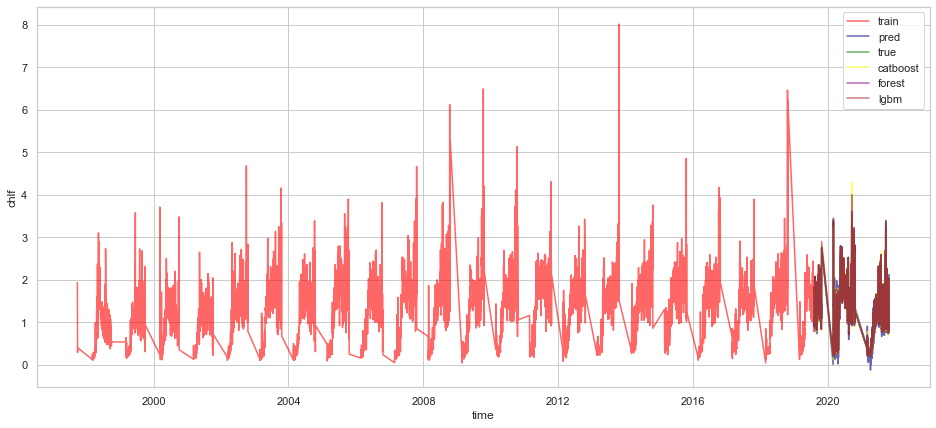

In [87]:
plt.figure(figsize=(16, 7))
sns.lineplot(x = y_train.index, y = y_train, alpha=0.6, color='red', label='train')
sns.lineplot(x = table_predictions['linear'].index, y = table_predictions['linear'], alpha=0.6, color ='navy', label='pred')
sns.lineplot(x = table_predictions['true'].index, y = table_predictions['true'], alpha=0.6, color='green', label='true')
sns.lineplot(x = table_predictions['catboost'].index, y = table_predictions['catboost'], alpha=0.6, color='yellow', label='catboost')
sns.lineplot(x = table_predictions['forest'].index, y = table_predictions['forest'], alpha=0.6, color='purple', label='forest')
sns.lineplot(x = table_predictions['lgbm'].index, y = table_predictions['lgbm'], alpha=0.6, color='brown', label='lgbm')

<AxesSubplot:xlabel='time', ylabel='chlf'>

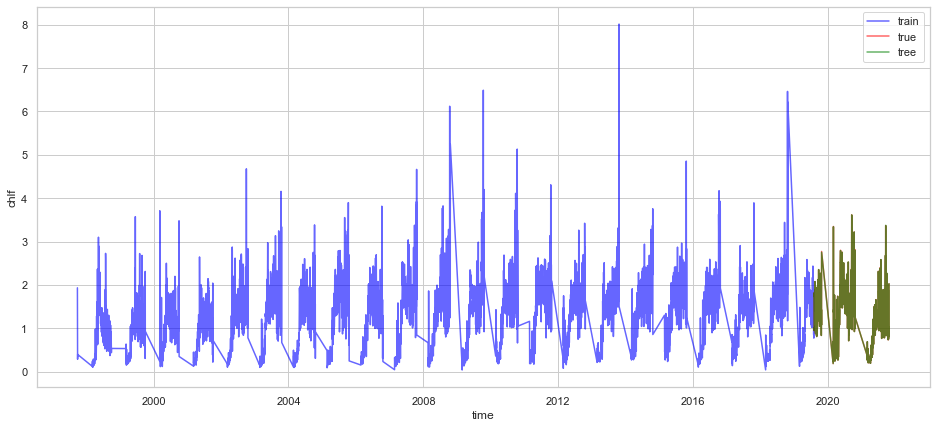

In [88]:
plt.figure(figsize=(16, 7))
sns.lineplot(x = y_train.index, y = y_train, alpha=0.6, color='blue', label='train')
sns.lineplot(x = table_predictions['true'].index, y = table_predictions['true'], alpha=0.6, color='red', label='true')
sns.lineplot(x = table_predictions['tree'].index, y = table_predictions['tree'], alpha=0.6, color='green', label='tree')

# df Temperature Moscow (Kaggle)

In [89]:
way = 'C:/Users/v.kozlovskiy/Desktop/_Data_collection_external/DATA_OUTER-20231027T194031Z-001/DATA_OUTER/Copernicus_time_series_chla/'

In [90]:
df = pd.read_csv(way + 'GlobalLandTemperaturesByMajorCity.csv')

<AxesSubplot:xlabel='dt'>

<Figure size 1152x504 with 0 Axes>

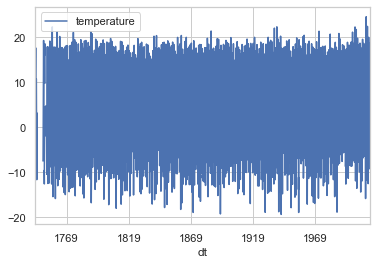

In [91]:
df = df.loc[df['City'] == 'Moscow']
df = df.set_index(pd.to_datetime(df['dt']))
df = df[['AverageTemperature']]
df.columns = ['temperature']

plt.figure(figsize=(16, 7))
df.plot()

In [92]:
df = df.loc[df.index > '1760-01-01']
df = df.dropna()

In [93]:
df.index.is_monotonic

True

<AxesSubplot:xlabel='dt'>

<Figure size 1152x504 with 0 Axes>

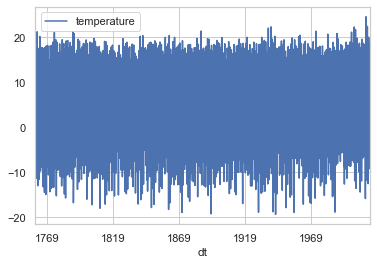

In [94]:
plt.figure(figsize=(16, 7))
df.plot()

Text(0.5, 1.0, 'temperature boxplot')

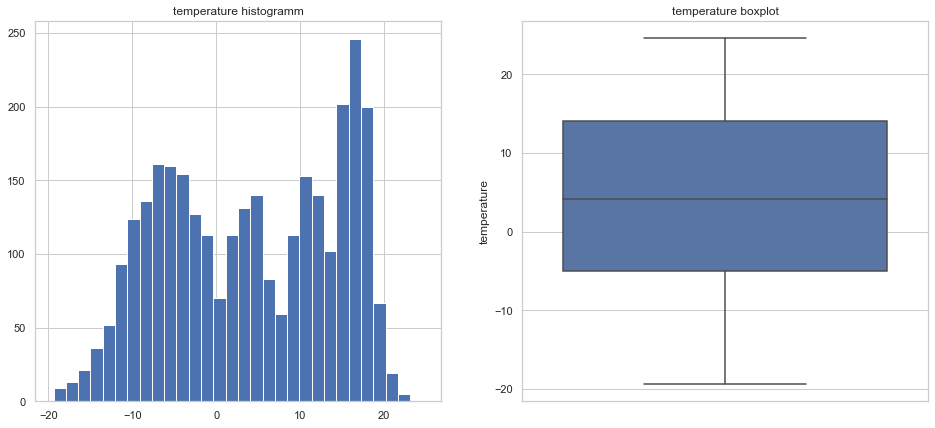

In [95]:
# boxplot and histogramm
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.subplot(1, 2, 1)
df['temperature'].hist(bins=30)
plt.title('temperature histogramm')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['temperature'])
plt.title('temperature boxplot')

<AxesSubplot:xlabel='dt', ylabel='temperature'>

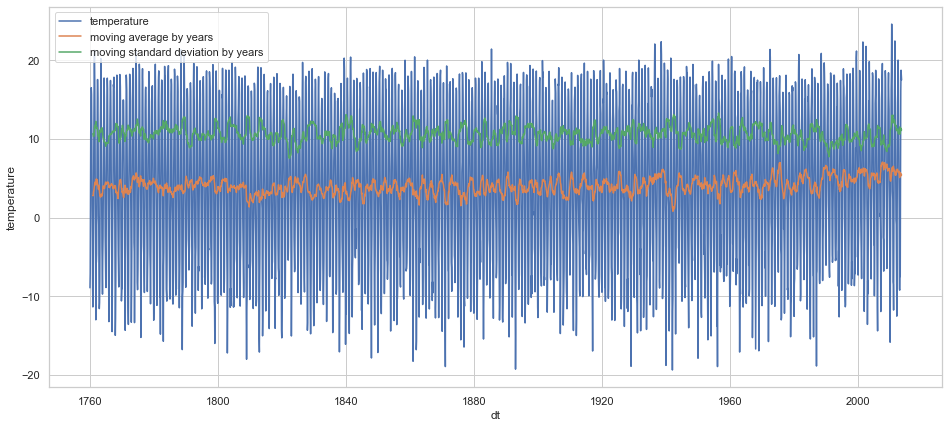

In [96]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(data=df, x=df.index, y=df['temperature'], label='temperature')
sns.lineplot(data=df, x=df.index, y=df['temperature'].rolling(12).mean(), label='moving average by years')
sns.lineplot(data=df, x=df.index, y=df['temperature'].rolling(12).std(), label='moving standard deviation by years')

In [97]:
p = sm.tsa.stattools.adfuller(df['temperature'].dropna())[1]
print(f'Dickey–Fuller test: p-value={p:.4f}')

Dickey–Fuller test: p-value=0.0000


In [98]:
decomposed_m = seasonal_decompose(df.dropna(), model='additive', period=12)

In [99]:
df.index.is_monotonic

True

<AxesSubplot:xlabel='dt'>

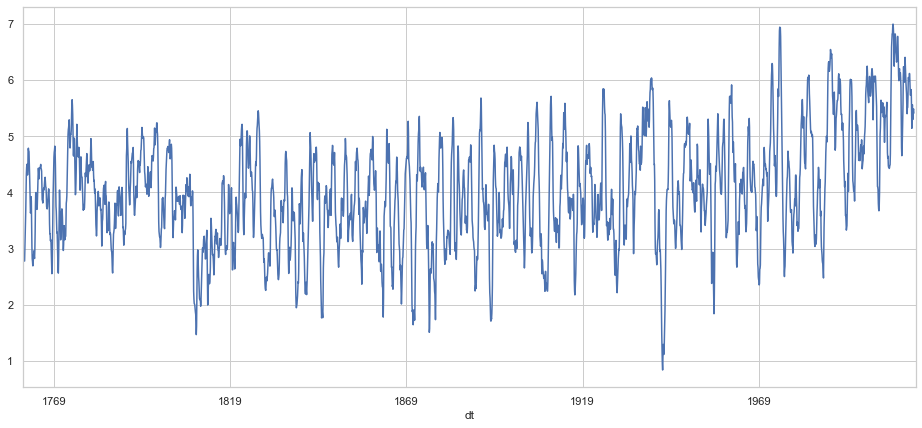

In [100]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
decomposed_m.trend.plot()

In [101]:
p = sm.tsa.stattools.adfuller(decomposed_m.trend.dropna())[1]
print(f'Dickey–Fuller test: p-value={p:.4f}')

Dickey–Fuller test: p-value=0.0000


<AxesSubplot:xlabel='dt'>

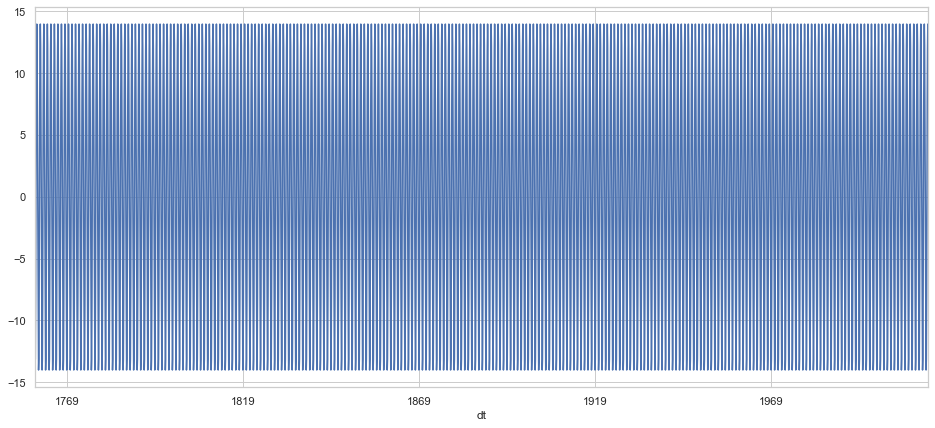

In [102]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
decomposed_m.seasonal.plot()

<AxesSubplot:xlabel='dt'>

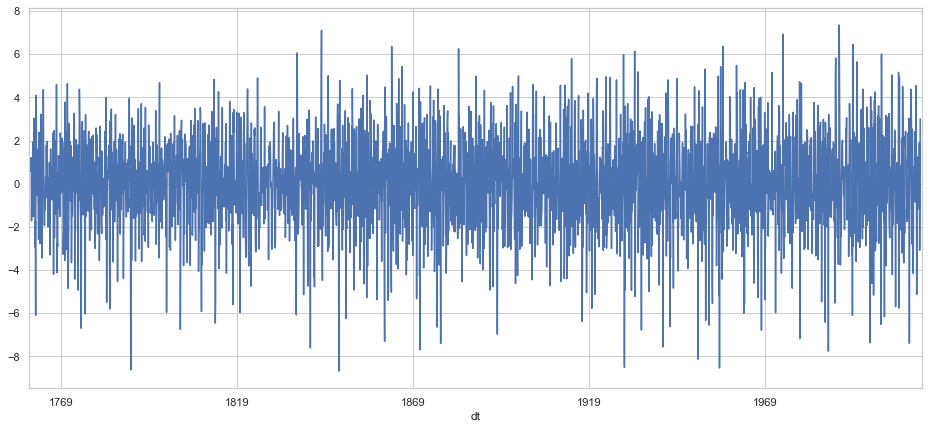

In [103]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
decomposed_m.resid.plot()

<AxesSubplot:xlabel='dt'>

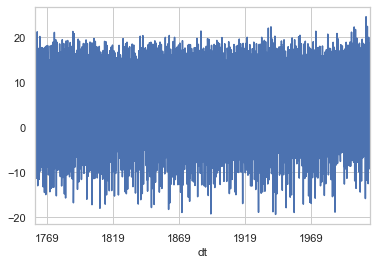

In [104]:
df['temperature'].plot()

In [105]:
#data2 = tab_m.loc[data2['num_orders'] > 0]
data2 = df
#data2['boxcox'], lmbda = stats.boxcox(data2['temperature'])
#data2['boxcox_shifted_S'] = data2.boxcox - data2.boxcox.shift(12)
#data2['boxcox_shifted'] = data2.boxcox_shifted_S - data2.boxcox_shifted_S.shift(1)
#data2 = data2[15:]

train_size = int(data2.shape[0] * 0.9)
df_train = data2.iloc[:train_size]
df_test = data2.iloc[train_size:]

print(df_train.shape)
print(df_test.shape)

data2

(2738, 1)
(305, 1)


,temperature
dt,
1760-02-01,-8.93
1760-03-01,-7.10
1760-04-01,1.88
1760-05-01,10.95
1760-06-01,15.18
...,...
2013-04-01,5.35
2013-05-01,16.15
2013-06-01,18.72


In [106]:
# function for making features
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['year'] = data.index.year    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['temperature'].shift(lag)
    data['rolling_mean_year'] = data['temperature'].shift().rolling(12).mean()
    return data

In [107]:
data2 = make_features(data2, 2)

In [108]:
data2 = data2[12:]
data2

,temperature,month,year,lag_1,lag_2,rolling_mean_year
dt,,,,,,
1761-02-01,-9.08,2,1761,-11.37,-9.08,2.78
1761-03-01,-1.64,3,1761,-9.08,-11.37,2.77
1761-04-01,3.23,4,1761,-1.64,-9.08,3.22
1761-05-01,12.98,5,1761,3.23,-1.64,3.34
1761-06-01,19.30,6,1761,12.98,3.23,3.51
...,...,...,...,...,...,...
2013-04-01,5.35,4,2013,-7.50,-4.73,5.39
2013-05-01,16.15,5,2013,5.35,-7.50,5.23
2013-06-01,18.72,6,2013,16.15,5.35,5.36


In [109]:
model = SARIMAX(df_train['temperature'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()

print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       temperature   No. Observations:                 2738
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7807.220
Date:                           Mon, 13 Nov 2023   AIC                          15624.439
Time:                                   17:14:12   BIC                          15653.999
Sample:                               02-01-1760   HQIC                         15635.123
                                    - 03-01-1988                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7271      0.022     33.139      0.000       0.684       0.770
ma.L1         -0.9992      0.007   -153.453

1988-04-01    2.10
1988-05-01    5.79
1988-06-01   10.20
1988-07-01   13.10
1988-08-01   12.89
Freq: MS, Name: predicted_mean, dtype: float64

(305,)


dt
1988-04-01    2.10
1988-05-01    5.79
1988-06-01   10.20
1988-07-01   13.10
1988-08-01   12.89
Name: predicted_mean, dtype: float64

RMSE: 9.90344537468931
MAE: 8.669785620603669


<AxesSubplot:xlabel='dt', ylabel='temperature'>

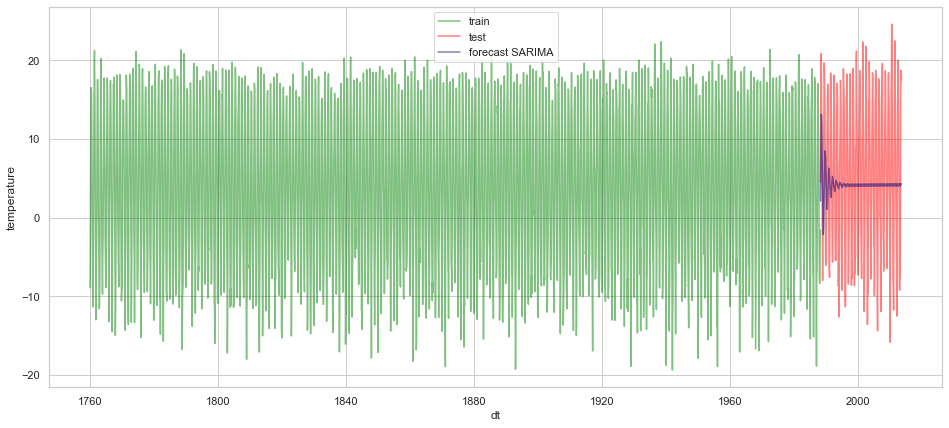

In [110]:
# forecast on fitted model
forecast = model_fit.forecast(steps=df_test.shape[0])
display(forecast[0:5])

compare = pd.Series(forecast)
compare.index = df_test['temperature'].index
print(compare.shape)
display(compare[0:5])

mse = mean_squared_error(df_test['temperature'], compare)**0.5
mae = mean_absolute_error(df_test['temperature'], compare)

print(f'RMSE: {mse}')
print(f'MAE: {mae}')

plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_train['temperature'].index, y = df_train['temperature'], alpha=0.5, color='green', label='train')
sns.lineplot(x = df_test['temperature'].index, y = df_test['temperature'], alpha=0.5, color='red', label='test')
sns.lineplot(x = compare.index, y = compare, alpha=0.5, color ='navy', label='forecast SARIMA')

# using stacionarity

In [111]:
df['temperature'].max()

24.58

In [112]:
data2 = df
df['temperature_for_box_cox'] = df['temperature'] + 24.59
data2['boxcox'], lmbda = stats.boxcox(df['temperature_for_box_cox'])
data2['boxcox_shifted_S'] = data2.boxcox - data2.boxcox.shift(12)
data2['boxcox_shifted'] = data2.boxcox_shifted_S - data2.boxcox_shifted_S.shift(1)
data2 = data2[15:]

#train_size = int(data2.shape[0] * 0.9)

train_size = -300
df_train = data2.iloc[:train_size]
df_test = data2.iloc[train_size:]

print(df_train.shape)
print(df_test.shape)

data2

(2728, 10)
(300, 10)


,temperature,month,year,lag_1,lag_2,rolling_mean_year,temperature_for_box_cox,boxcox,boxcox_shifted_S,boxcox_shifted
dt,,,,,,,,,,
1761-05-01,12.98,5,1761,3.23,-1.64,3.34,37.57,28.42,1.45,0.46
1761-06-01,19.30,6,1761,12.98,3.23,3.51,43.89,32.89,2.91,1.47
1761-07-01,21.23,7,1761,19.30,12.98,3.85,45.82,34.25,3.32,0.41
1761-08-01,17.45,8,1761,21.23,19.30,4.24,42.04,31.59,1.29,-2.03
1761-09-01,11.99,9,1761,17.45,21.23,4.40,36.58,27.71,0.79,-0.50
...,...,...,...,...,...,...,...,...,...,...
2013-04-01,5.35,4,2013,-7.50,-4.73,5.39,29.94,22.93,-1.37,1.68
2013-05-01,16.15,5,2013,5.35,-7.50,5.23,40.74,30.67,1.10,2.48
2013-06-01,18.72,6,2013,16.15,5.35,5.36,43.31,32.48,1.68,0.58


Dickey–Fuller test: p-value=0.0
                                     SARIMAX Results                                     
Dep. Variable:                    boxcox_shifted   No. Observations:                 2728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6591.105
Date:                           Mon, 13 Nov 2023   AIC                          13192.210
Time:                                   17:14:15   BIC                          13221.752
Sample:                               05-01-1761   HQIC                         13202.889
                                    - 08-01-1988                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3885      0.016    -23.904      0.000      -0.420      -0.357
ma.L1      

<AxesSubplot:xlabel='dt', ylabel='temperature'>

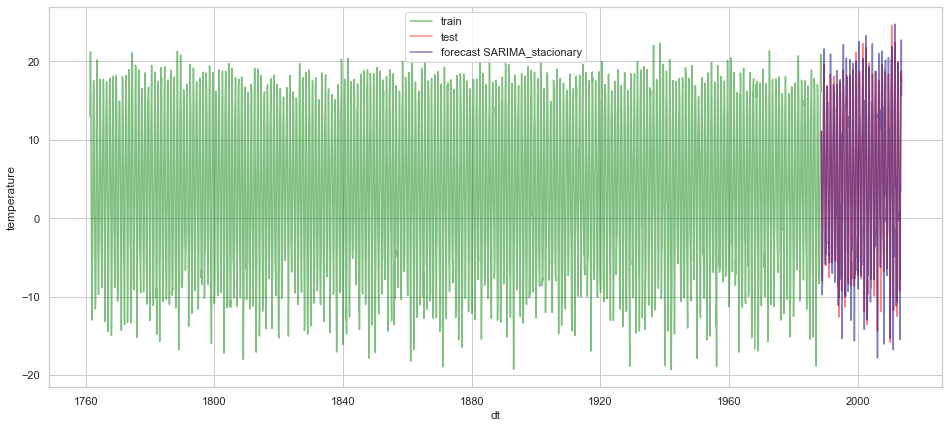

In [113]:
p = sm.tsa.stattools.adfuller(data2.boxcox_shifted)[1]
print(f'Dickey–Fuller test: p-value={p}')

def resore_prediction(y_pred):
    y_pred += data2.boxcox_shifted_S.shift(1)[train_size:]
    y_pred += data2.boxcox.shift(12)[train_size:]
    y_pred = inv_boxcox(y_pred, lmbda)
    y_pred = y_pred - 24.59
    return y_pred


model = SARIMAX(df_train['boxcox_shifted'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()


print(model_fit.summary())

df_test.shape[0]


forecast = model_fit.forecast(steps=df_test.shape[0])
forecast[0:5]

compare = pd.Series(forecast)
compare.index = df_test['boxcox_shifted'].index
print(compare.shape)
compare[0:5]

y_pred = resore_prediction(compare)

y_pred[0:5]


mse = mean_squared_error(df_test['temperature'], y_pred)**0.5
mae = mean_absolute_error(df_test['temperature'], y_pred)

print(f'RMSE: {mse}')
print(f'MAE: {mae}')

plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_train['temperature'].index, y = df_train['temperature'], alpha=0.5, color='green', label='train')
sns.lineplot(x = df_test['temperature'].index, y = df_test['temperature'], alpha=0.5, color='red', label='test')
sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color ='navy', label='forecast SARIMA_stacionary')

<AxesSubplot:xlabel='dt', ylabel='temperature'>

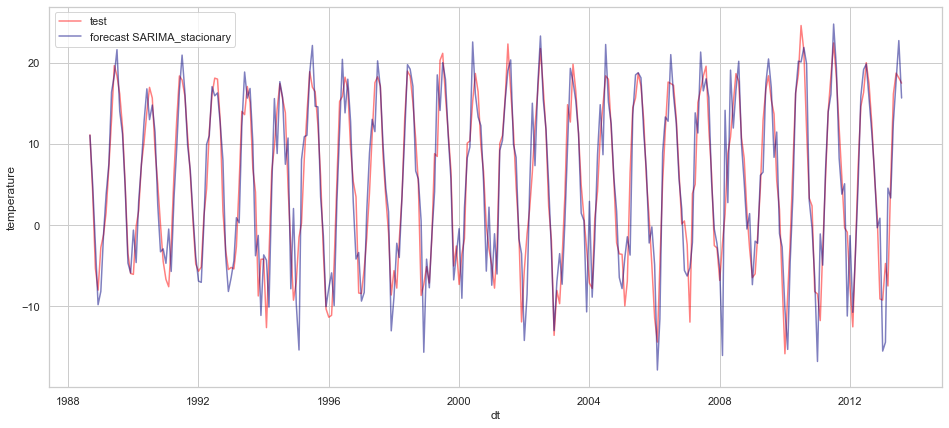

In [114]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_test['temperature'].index, y = df_test['temperature'], alpha=0.5, color='red', label='test')
sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color ='navy', label='forecast SARIMA_stacionary')

<AxesSubplot:xlabel='dt', ylabel='temperature'>

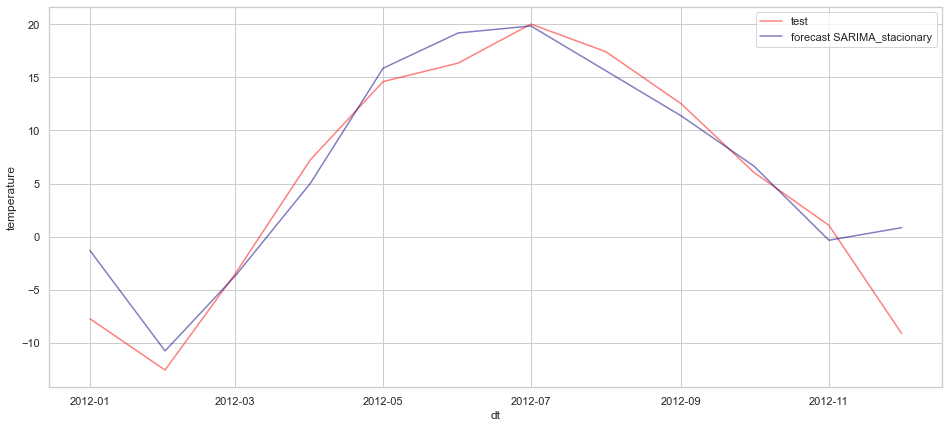

In [115]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = df_test.loc[df_test.index.year == 2012]['temperature'].index, y = df_test.loc[df_test.index.year == 2012]['temperature'], alpha=0.5, color='red', label='test')
sns.lineplot(x = y_pred.loc[y_pred.index.year == 2012].index, y = y_pred.loc[y_pred.index.year == 2012], alpha=0.5, color ='navy', label='forecast SARIMA_stacionary')

### Future forecast

In [116]:
df.index.max()

Timestamp('2013-08-01 00:00:00')

                                     SARIMAX Results                                     
Dep. Variable:                    boxcox_shifted   No. Observations:                 2728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -6591.105
Date:                           Mon, 13 Nov 2023   AIC                          13192.210
Time:                                   17:14:20   BIC                          13221.752
Sample:                               05-01-1761   HQIC                         13202.889
                                    - 08-01-1988                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3885      0.016    -23.904      0.000      -0.420      -0.357
ma.L1         -0.9995      0.073    -13.750

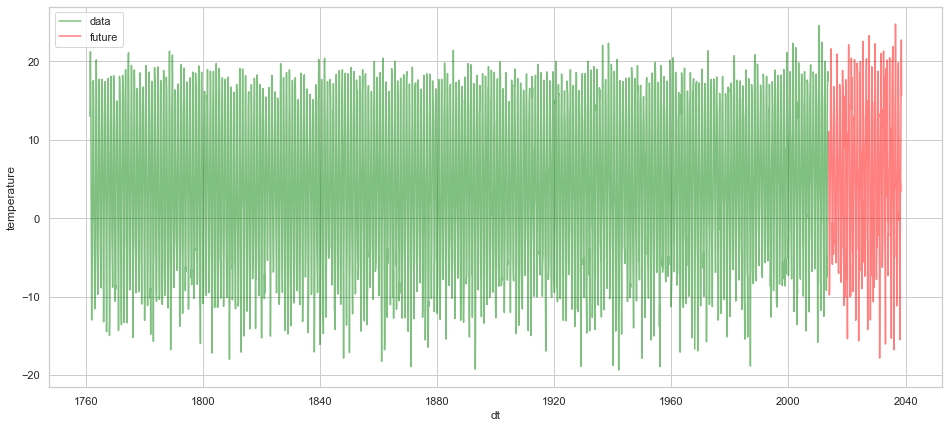

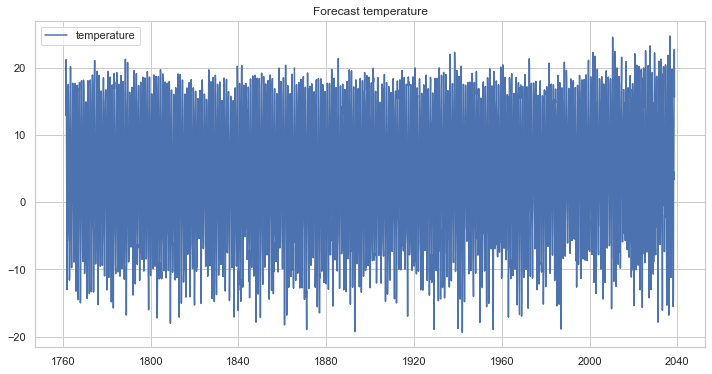

In [117]:
data2.index.max()


model = SARIMAX(df_train['boxcox_shifted'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit()


print(model_fit.summary())


forecast_future = model_fit.forecast(steps=df_test.shape[0])


future_dates = pd.date_range(start='2013-09-01 00:00:00', periods=df_test.shape[0], freq='M')
#forecast_df = pd.DataFrame({'date': future_dates, 'boxcox_shifted': forecast_future})
#forecast_df = forecast_df.set_index('date')

def resore_prediction(y_pred):
    y_pred += data2.boxcox_shifted_S.shift(1)[train_size:]
    y_pred += data2.boxcox.shift(12)[train_size:]
    y_pred = inv_boxcox(y_pred, lmbda)
    y_pred = y_pred - 24.59
    return y_pred

compare = pd.Series(forecast_future)
compare.index = df_test['boxcox_shifted'].index
print(compare.shape)
compare[0:5]

y_pred = resore_prediction(compare)
y_pred[0:5]

y_pred.index = future_dates
y_pred[0:5]

plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = data2['temperature'].index, y = data2['temperature'], alpha=0.5, color='green', label='data')
sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color='red', label='future')
#sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color ='navy', label='forecast SARIMA_stacionary')

tab_exp = pd.concat([pd.DataFrame({'temperature': data2['temperature']}), pd.DataFrame({'temperature':y_pred})], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(tab_exp.index, tab_exp['temperature'], label='temperature')

plt.title('Forecast temperature')
plt.legend()
plt.grid(True)
plt.show()

<AxesSubplot:ylabel='predicted_mean'>

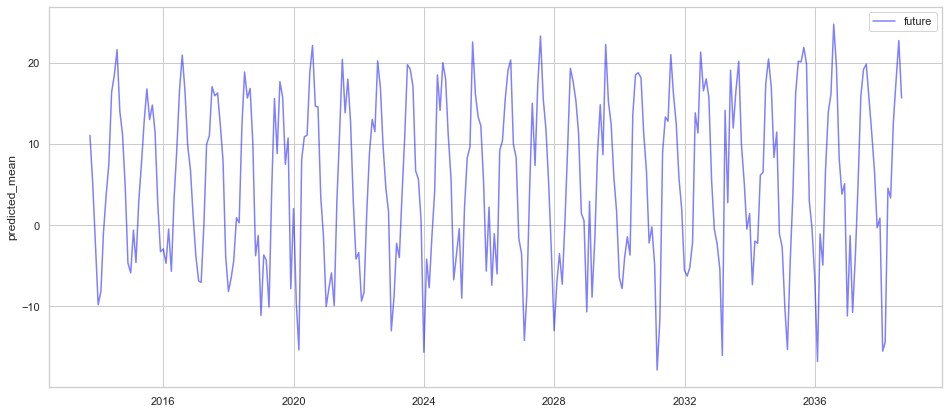

In [118]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = y_pred.index, y = y_pred, alpha=0.5, color='blue', label='future')

In [119]:
temp_fc = y_pred.loc[(y_pred.index.year < 2025) & (y_pred.index.year > 2022)]

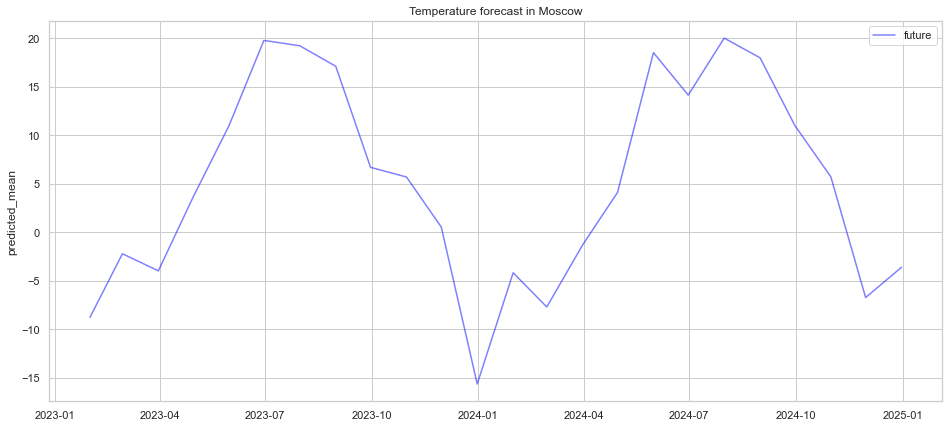

In [120]:
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
sns.lineplot(x = temp_fc.index, y = temp_fc, alpha=0.5, color='blue', label='future')
plt.title('Temperature forecast in Moscow')
#plt.xlabel('Date')
#plt.ylabel('num_orders')
plt.legend()
plt.grid(True)
plt.show()

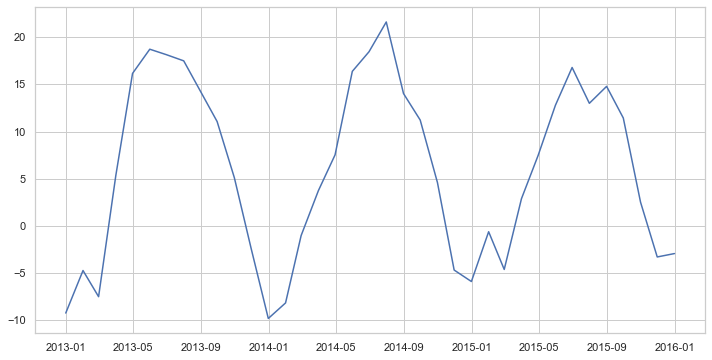

In [121]:
# check connection
tab_exp2 = tab_exp.loc[(tab_exp.index.year >= 2013) & (tab_exp.index.year <= 2015)]
plt.figure(figsize=(12, 6))
plt.plot(tab_exp2.index, tab_exp2['temperature'], label='temperature')